# Project Census WFH   
The goal of this workbook is to compare the efficacy of machine learning models based on different levels of spacial consolidation, based on the [Australian Statistical Geography Standard](https://www.abs.gov.au/websitedbs/D3310114.nsf/home/Australian+Statistical+Geography+Standard+(ASGS)) framework. the key questions are:   

- Can we find a model for predicting with an R2 value > 0.7? (Based on [prior work](https://github.com/blkemp/ABS-Region-Data/tree/BKSubmission), I suspect the answer is yes).
- Using this model, what is the impact on accuracy for feeding in data that is consolidated at a different level (e.g. neighborhood vs city vs county)?
- How do models trained at differing levels of granularity compare in both baseline accuracy and generalisability? I.e. Are models trained with the most fine grained data more accurate, or are they prone to overfitting?

As a starting point I will be utilising the [Australian Bureau of Statistics 2016 Census Datapacks](https://datapacks.censusdata.abs.gov.au/datapacks/) and attempting to predict "working from home" behaviours by region. Why this particular response vector? a) It just seems interesting and b) I suspect that demographic information available within the census itself (gender, age, profession and industry) will all be strongly related to both individuals' propensity to undertake working from home and their ability to do so with support from employers.

### Metrics for evaluation
It may be expected that because we are comparing model efficacy it would be worthwhile exploring RMSE as noted [here](https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4). Given the increasing variance in the predicted outcome at different SA levels, by failing to take the population variance into account RMSE will tend to inflate the error rate of the models trained on more disaggregated SA levels. Accordingly, I have been focused on R2 score as a metric (due to my desire to explore the explanatory power of models). 

I considered using Adjusted R<sup>2</sup>, but the high dimensionality simply made the results irrelevant (Adjusted R<sup>2</sup> is supposed to always be lower than R<sup>2</sup>, and this was not the case where n samples < k parameters as often occurred at the SA3 level). Additionally, since the number of features is the same between models, the only driver of differences between Adjusted R<sup>2</sup> and regular R<sup>2</sup> is the sample size. Given the entire point of this analysis is to determine the power of having more training samples, using a metric which seeks to mitigate this as a factor seemed disingenuous.

In [1]:
# Import statements
# Declare Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import os
import pickle
from textwrap import wrap
import operator
import au_census_analysis_functions as cnss_func

# Set a variable for current notebook's path for various loading/saving mechanisms
nb_path = os.getcwd()

In [13]:
import importlib
importlib.reload(cnss_func)

<module 'au_census_analysis_functions' from 'C:\\Users\\kempbri\\OneDrive - Mars Inc\\Documents\\GitHub\\Census-ASGS-Level-and-Model-Sensitivity\\au_census_analysis_functions.py'>

### Custom Functions
Below creates a number of custom functions. These are also replicated in the au_census_analysis_functions.py file but for the time being I am leaving them here if I need to re-run some of the cells executed prior to the implementation of these as imported functions.

In [2]:
# Show tables which have the above fields of information available
df_meta = pd.read_csv('{}\Data\Metadata\Metadata_2016_refined.csv'.format(nb_path))
df_m_refined = df_meta[(df_meta['Age'] > 0) |
                      (df_meta['Income'] > 0) |
                      (df_meta['Occupation'] > 0) |
                      (df_meta['Family Composition'] > 0) |
                      (df_meta['Internet status'] > 0) |
                      (df_meta['Building occupation status'] > 0) |
                      (df_meta['Number of Bedrooms'] > 0) |
                      (df_meta['Place of Birth'] > 0) |
                      (df_meta['Country of Birth of Parents'] > 0) |
                      (df_meta['Year of Arrival'] > 0)]
tables_to_load = df_m_refined['Profile table'].unique().tolist()
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']

In [4]:
# build a pipelines to fill NaNs with medians
#note to self, it may be interesting to explore the functionality of IUterativeImputer instead of SimpleImputer
def build_model():
    ''' Impute for missing values and build a model to complete a quick
    Grid search over RandomForestRegressor key parameters.
    '''
    pipeline_model = Pipeline([
        ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('clf', RandomForestRegressor(n_estimators=100, random_state=42, max_depth=100))
    ])
    # specify parameters for grid search
    parameters = {'clf__n_estimators':[20,40], # this used to start at 10 and go to 80 but was a huge timesuck and not improving performance
              'clf__max_depth':[16,32,64], # this used to go to 128 but had no impact on performance
              #'clf__min_samples_leaf':[1,2,4] This wasn't really having an impact on performance
             }

    # create grid search object
    scorer = make_scorer(r2_score)
    cv = GridSearchCV(pipeline_model, param_grid=parameters, scoring=scorer, verbose = 3)

    return cv

In [5]:
def model_WFH(stat_a_level):
    # Load table 59 (the one with commute mechanism) and have a quick look at the distribution of WFH by sex
    df_travel = cnss_func.load_table_refined('G59', ['Number of Commuting Methods'], statistical_area_code=stat_a_level)
    cols_to_delete = [x for x in df_travel.columns if 'Worked_at_home' not in x]
    df_travel.drop(cols_to_delete,axis=1, inplace=True)

    df_pop = cnss_func.load_census_csv(['G01'], statistical_area_code=stat_a_level)
    df_pop.set_index(df_pop.columns[0], inplace=True)
    df_pop = df_pop.drop([x for x in df_pop.columns if 'Tot_P_P' not in x], axis=1)
    df_travel = df_travel.merge(df_pop, left_index=True, right_index=True)
    
    # Create new "Work From Home Participation Rate" vector to ensure consistency across regions
    # Base this off population who worked from home divided by total population in the region
    df_travel['WFH_Participaction'] = (df_travel['Method of Travel to Work by Sex|Worked_at_home']/
                                       df_travel['Tot_P_P'])
    # Drop the original absolute values column
    df_travel = df_travel.drop(['Method of Travel to Work by Sex|Worked_at_home'], axis=1)
    
    # load input vectors
    load_tables = tables_to_load
    load_features = ['Age','Income','Occupation',
                     'Family Composition','Internet status',
                     'Building occupation status','Number of Bedrooms',
                     'Place of Birth','Country of Birth of Parents','Year of Arrival']
    
    input_vectors = cnss_func.load_tables_specify_cats(load_tables, load_features, statistical_area_code=stat_a_level)
    
    # Remove duplicate column values
    input_vectors = input_vectors.T.drop_duplicates().T

    # Bring in total population field and scale all the values by this item
    input_vectors = input_vectors.merge(df_pop, left_index=True, right_index=True)

    # convert input features to numeric
    cols = input_vectors.columns
    input_vectors[cols] = input_vectors[cols].apply(pd.to_numeric, errors='coerce')

    # Drop rows with zero population
    input_vectors = input_vectors.dropna(subset=['Tot_P_P'])
    input_vectors = input_vectors[input_vectors['Tot_P_P'] > 0]

    # Scale all factors by total region population
    for cols in input_vectors.columns:
        if 'Tot_P_P' not in cols:
            input_vectors[cols] = input_vectors[cols]/input_vectors['Tot_P_P']

    # merge and drop na values from the response vector
    df_travel = df_travel.merge(input_vectors, left_index=True, right_index=True)
    df_travel = df_travel.dropna(subset=['WFH_Participaction'])

    df_travel = df_travel.drop([x for x in df_travel.columns if 'Tot_P_P' in x], axis=1)

    # Remove duplicate column values
    df_travel = df_travel.T.drop_duplicates().T

    # Investigate correlations to check out items which stand out as potential drivers
    response_vector = 'WFH_Participaction'

    # Create X & y
    X = df_travel.drop(response_vector, axis=1)
    y = df_travel[response_vector]

    # Split the 'features' and 'response' vectors into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    # build a model using all the above inputs
    grid_obj = build_model()

    # TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    return grid_fit.best_estimator_, X_train, X_test, y_train, y_test, X

In [6]:
def model_analyse_pred(X_test, y_test, model):
    preds = model.predict(X_test)
    lineStart = min(preds.min(), y_test.min())  
    lineEnd = max(preds.max()*1.2, y_test.max()*1.2)

    plt.figure()
    plt.scatter(preds, y_test, color = 'k', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.text(y_test.max()/5, y_test.max(), 'R2 Score: {:.3f}'.format(r2_score(y_test, preds)))
    plt.show()

In [109]:
def load_WFHPR(sa_level):
    # Loads the column to be used as an outcome in prediction models
    df_response = cnss_func.load_table_refined('G59', ['Number of Commuting Methods'], statistical_area_code=sa_level)
    cols_to_delete = [x for x in df_response.columns if 'Worked_at_home' not in x]
    df_response.drop(cols_to_delete,axis=1, inplace=True)

    df_pop = cnss_func.load_census_csv(['G01'], statistical_area_code=sa_level)
    df_pop.set_index(df_pop.columns[0], inplace=True)
    df_pop = df_pop.drop([x for x in df_pop.columns if 'Tot_P_P' not in x], axis=1)
    df_response = df_response.merge(df_pop, left_index=True, right_index=True)

    # Create new "Work From Home Participation Rate" vector to ensure consistency across regions
    # Base this off population who worked from home divided by total population in the region
    df_response['WFH_Participation'] = (df_response['Method of Travel to Work by Sex|Worked_at_home']/
                                         df_response['Tot_P_P'])
    # Drop the original absolute values column
    df_response = df_response.drop(['Method of Travel to Work by Sex|Worked_at_home'], axis=1)
    df_response = df_response.drop(['Tot_P_P'], axis=1)
    return df_response

## Begin importing and exploring data

In [7]:
# Import metadata sheets
df_meta_tables = pd.read_excel('{}\Data\Metadata\Metadata_2016_GCP_DataPack.xlsx'.format(nb_path),
                               sheet_name = 'Table number, name, population',
                               skiprows=9)
df_meta_measures = pd.read_excel('{}\Data\Metadata\Metadata_2016_GCP_DataPack.xlsx'.format(nb_path),
                               sheet_name = 'Cell descriptors information',
                               skiprows=10)

In [8]:
df_meta_tables.tail()

Table number                                         Table name  \
54          G55  Total Family Income (Weekly) by Labour Force S...   
55          G56  Total Family Income (Weekly) by Labour Force S...   
56          G57                           Occupation by Age by Sex   
57          G58                  Occupation by Hours Worked by Sex   
58          G59                    Method of Travel to Work by Sex   

                            Table population  
54             Couple families with children  
55                       One parent families  
56  Employed persons aged 15 years and over   
57  Employed persons aged 15 years and over   
58  Employed persons aged 15 years and over

In [9]:
df_meta_measures['Table number'] = df_meta_measures['DataPack file'].str[:3]

In [10]:
df_meta_measures = pd.merge(df_meta_measures, df_meta_tables, on='Table number')

At this point I realised a great deal of work needed to go into navigating the census data. Workings are available in the "Census data navigation workings.ipynb" file in this repo.

### Define top level categories of information for training

First I want to see the impact of training with and without a gender split. so I'm not going to include that in my categories list. My intuition tells me that the below features should have some form of influence on the ability of someone to work from home:   

- **Age** - I suspect there is a certain trend within particular generations to work from home, as well as a stage-of-career factor that often ties to a person's age that could be reflected. 
- **Income** - Higher skillsets have greater remuneration and flexibility to work from home.
- **Occupation** - Particular industries have the ability to work from home (software development) wheras others do not (car maintenance).
- **Family Composition** - I'm actually interested to see what this shows. Are parents more likely to work from home or people who are single?
- **Internet status** - I'd expect the ability to work from home is contingent on having internet access.   

I may choose to add in a few more tenuous links such as:
- **Building occupation status** - Are home owners or renters more likely to WFH?
- **Family with children type** - Further insight into how are parents more likely to work from home, does age of child have an influence (pre-school vs at school)?
- **Number of Bedrooms** - Are bigger houses more or less likely to entice someone to WFH?
- **Place of Birth** - Are there trends in birthplace that indicate WFH status? Cultural factors or simple immigrant vs non.
- **Country of Birth of Parents** - Potential influence on propentsity to WFH based on household cultural factors.
- **Year of Arrival** - Again, could be an interesting proxy for cultural factors influencing propensity to WFH.

I will also need to import the "Method of travel to work" table and remove all other methods of travel other than "Worked from home" as this would be a far too obvious mechanism to determine if someone commuted or not.

In [11]:
# Show tables which have the above fields of information available
df_meta = pd.read_csv('{}\Data\Metadata\Metadata_2016_refined.csv'.format(nb_path))
df_m_refined = df_meta[(df_meta['Age'] > 0) |
                      (df_meta['Income'] > 0) |
                      (df_meta['Occupation'] > 0) |
                      (df_meta['Family Composition'] > 0) |
                      (df_meta['Internet status'] > 0) |
                      (df_meta['Building occupation status'] > 0) |
                      (df_meta['Number of Bedrooms'] > 0) |
                      (df_meta['Place of Birth'] > 0) |
                      (df_meta['Country of Birth of Parents'] > 0) |
                      (df_meta['Year of Arrival'] > 0)]
tables_to_load = df_m_refined['Profile table'].unique().tolist()
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']

In [12]:
tables_to_load = df_m_refined['Profile table'].unique().tolist()
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']

In [13]:
# Load table 59 (the one with commute mechanism) and have a quick look at the distribution of WFH by sex
df_travel = cnss_func.load_table_refined('G59', ['Number of Commuting Methods'], statistical_area_code='SA3')

In [14]:
df_travel_sex = cnss_func.load_table_refined('G59', ['Sex','Number of Commuting Methods'], statistical_area_code='SA3')

In [15]:
df_travel = df_travel.merge(df_travel_sex, left_index=True, right_index=True)

In [16]:
cols_to_delete = [x for x in df_travel.columns if 'Worked_at_home' not in x]
df_travel.drop(cols_to_delete,axis=1, inplace=True)
df_travel.head()

Area_index  Method of Travel to Work by Sex|Worked_at_home  \
10102                                                 1134   
10103                                                  777   
10104                                                 1788   
10105                                                  994   
10106                                                 1424   

Area_index  Method of Travel to Work by Sex|Worked_at_home_Females  \
10102                                                     674        
10103                                                     385        
10104                                                     963        
10105                                                     473        
10106                                                     695        

Area_index  Method of Travel to Work by Sex|Worked_at_home_Males  
10102                                                     459     
10103                                                     388     
10104                                                     825     
10105                                                     519     
10106                                                     724

[]

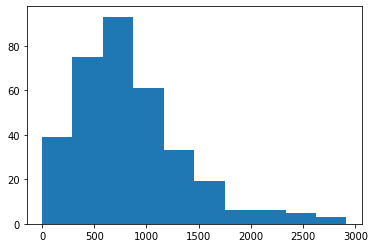

In [17]:
plt.hist(df_travel['Method of Travel to Work by Sex|Worked_at_home_Females'])
plt.plot()

[]

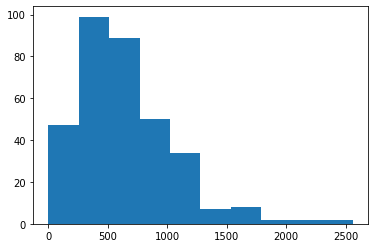

In [18]:
plt.hist(df_travel['Method of Travel to Work by Sex|Worked_at_home_Males'])
plt.plot()

In [19]:
# Look at the basic statistical comparisons between the two distributions
import scipy.stats  as stats
compar_stats =  stats.pearsonr(df_travel['Method of Travel to Work by Sex|Worked_at_home_Males'], 
                               df_travel['Method of Travel to Work by Sex|Worked_at_home_Females'])
print('Pearson Coeff: {} \n P-Value: {}'.format(compar_stats[0],compar_stats[1]))

Pearson Coeff: 0.9227147512611741 
 P-Value: 5.518338569350439e-142


There seems to be more of a right skew to the data for Males working from home, so my basic hypothesis of testing whether there is a meaningful difference between models trained on total data vs gendered data may be worth exploring. That said, the p-value itself is incredibly low, so maybe I want to disaggregate a little further before really honing in on this. Then again, maybe that's p-hacking and I'm being evil in even contemplating that!

In [20]:
df_pop = cnss_func.load_census_csv(['G01'], statistical_area_code='SA3')
df_pop.set_index(df_pop.columns[0], inplace=True)
df_pop = df_pop.drop([x for x in df_pop.columns if x != 'Tot_P_P'], axis=1)

In [21]:
df_travel = df_travel.merge(df_pop, left_index=True, right_index=True)
df_travel.head()

Method of Travel to Work by Sex|Worked_at_home  \
10102                                            1134   
10103                                             777   
10104                                            1788   
10105                                             994   
10106                                            1424   

       Method of Travel to Work by Sex|Worked_at_home_Females  \
10102                                                674        
10103                                                385        
10104                                                963        
10105                                                473        
10106                                                695        

       Method of Travel to Work by Sex|Worked_at_home_Males  Tot_P_P  
10102                                                459       57331  
10103                                                388       19366  
10104                                                825       70638  
10105                                                519       35559  
10106                                                724       35942

In [22]:
# Create new "Work From Home Participation Rate" vector to ensure consistency across regions
# Base this off population who worked from home divided by total population in the region
df_travel['WFH_Participaction'] = (df_travel['Method of Travel to Work by Sex|Worked_at_home']/
                                   df_travel['Tot_P_P'])
df_travel.head()

Method of Travel to Work by Sex|Worked_at_home  \
10102                                            1134   
10103                                             777   
10104                                            1788   
10105                                             994   
10106                                            1424   

       Method of Travel to Work by Sex|Worked_at_home_Females  \
10102                                                674        
10103                                                385        
10104                                                963        
10105                                                473        
10106                                                695        

       Method of Travel to Work by Sex|Worked_at_home_Males  Tot_P_P  \
10102                                                459       57331   
10103                                                388       19366   
10104                                                825       70638   
10105                                                519       35559   
10106                                                724       35942   

       WFH_Participaction  
10102            0.019780  
10103            0.040122  
10104            0.025312  
10105            0.027954  
10106            0.039619

In [23]:
# load input vectors
load_tables = tables_to_load
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']
input_vectors = cnss_func.load_tables_specify_cats(load_tables, load_features, statistical_area_code='SA3')
# Remove duplicate column values
input_vectors = input_vectors.T.drop_duplicates().T

# Bring in total population field and scale all the values by this item
input_vectors = input_vectors.merge(df_pop, left_index=True, right_index=True)

# convert input features to numeric
cols = input_vectors.columns
input_vectors[cols] = input_vectors[cols].apply(pd.to_numeric, errors='coerce')

In [24]:
# Drop rows with zero population
input_vectors = input_vectors.dropna(subset=['Tot_P_P'])
input_vectors = input_vectors[input_vectors['Tot_P_P'] > 0]

# Scale all factors by total region population
for cols in input_vectors.columns:
    if cols !='Tot_P_P':
        input_vectors[cols] = input_vectors[cols]/input_vectors['Tot_P_P']

input_vectors.head()

Selected Person Characteristics by Sex|Age_groups_0_4_years  \
10102                                           0.064956             
10103                                           0.046628             
10104                                           0.041833             
10105                                           0.058354             
10106                                           0.061488             

       Selected Person Characteristics by Sex|Age_groups_15_19_years  \
10102                                           0.062619               
10103                                           0.058246               
10104                                           0.051007               
10105                                           0.059113               
10106                                           0.062239               

       Selected Person Characteristics by Sex|Age_groups_20_24_years  \
10102                                           0.057351               
10103                                           0.053806               
10104                                           0.034910               
10105                                           0.052982               
10106                                           0.046881               

       Selected Person Characteristics by Sex|Age_groups_25_34_years  \
10102                                           0.135982               
10103                                           0.111691               
10104                                           0.072213               
10105                                           0.112714               
10106                                           0.090952               

       Selected Person Characteristics by Sex|Age_groups_35_44_years  \
10102                                           0.140378               
10103                                           0.120211               
10104                                           0.092613               
10105                                           0.116004               
10106                                           0.122086               

       Selected Person Characteristics by Sex|Age_groups_45_54_years  \
10102                                           0.160105               
10103                                           0.150212               
10104                                           0.132195               
10105                                           0.138474               
10106                                           0.143453               

       Selected Person Characteristics by Sex|Age_groups_55_64_years  \
10102                                           0.125081               
10103                                           0.143086               
10104                                           0.183641               
10105                                           0.138165               
10106                                           0.136609               

       Selected Person Characteristics by Sex|Age_groups_5_14_years  \
10102                                           0.131029              
10103                                           0.122276              
10104                                           0.108398              
10105                                           0.121488              
10106                                           0.140254              

       Selected Person Characteristics by Sex|Age_groups_65_74_years  \
10102                                           0.077201               
10103                                           0.113240               
10104                                           0.165577               
10105                                           0.114879               
10106                                           0.115519               

       Selected Person Characteristics by Sex|Age_groups_75_84_years  ...  \
10102                                           0.0

In [25]:
# merge and drop na values from the response vector
df_travel = df_travel.merge(input_vectors, left_index=True, right_index=True)
df_travel = df_travel.dropna(subset=['WFH_Participaction'])

In [28]:
cols_to_delete = [x for x in df_travel.columns if 'Worked_at_home' in x]
df_travel.drop(cols_to_delete,axis=1, inplace=True)

cols_to_delete = [x for x in df_travel.columns if 'Tot_P_P' in x]
df_travel.drop(cols_to_delete,axis=1, inplace=True)

df_travel.head()

WFH_Participaction  \
10102            0.019780   
10103            0.040122   
10104            0.025312   
10105            0.027954   
10106            0.039619   

       Selected Person Characteristics by Sex|Age_groups_0_4_years  \
10102                                           0.064956             
10103                                           0.046628             
10104                                           0.041833             
10105                                           0.058354             
10106                                           0.061488             

       Selected Person Characteristics by Sex|Age_groups_15_19_years  \
10102                                           0.062619               
10103                                           0.058246               
10104                                           0.051007               
10105                                           0.059113               
10106                                           0.062239               

       Selected Person Characteristics by Sex|Age_groups_20_24_years  \
10102                                           0.057351               
10103                                           0.053806               
10104                                           0.034910               
10105                                           0.052982               
10106                                           0.046881               

       Selected Person Characteristics by Sex|Age_groups_25_34_years  \
10102                                           0.135982               
10103                                           0.111691               
10104                                           0.072213               
10105                                           0.112714               
10106                                           0.090952               

       Selected Person Characteristics by Sex|Age_groups_35_44_years  \
10102                                           0.140378               
10103                                           0.120211               
10104                                           0.092613               
10105                                           0.116004               
10106                                           0.122086               

       Selected Person Characteristics by Sex|Age_groups_45_54_years  \
10102                                           0.160105               
10103                                           0.150212               
10104                                           0.132195               
10105                                           0.138474               
10106                                           0.143453               

       Selected Person Characteristics by Sex|Age_groups_55_64_years  \
10102                                           0.125081               
10103                                           0.143086               
10104                                           0.183641               
10105                                           0.138165               
10106                                           0.136609               

       Selected Person Characteristics by Sex|Age_groups_5_14_years  \
10102                                           0.131029              
10103                                           0.122276              
10104                                           0.108398              
10105                                           0.121488              
10106                                           0.140254              

       Selected Person Characteristics by Sex|Age_groups_65_74_years  ...  \
10102                                           0.077201              ...   
10103                                           0.113240              ...   
10104                                           0.165577              ...   
10105                                           0.114879              ...   
1

In [29]:
# Remove duplicate column values
df_travel = df_travel.T.drop_duplicates().T

In [30]:
# Investigate correlations to check out items which stand out as potential drivers
response_vector = 'WFH_Participaction'
cnss_func.sort_series_abs(df_travel.corr().loc[:,response_vector])[1:50]

Occupation by Age by Sex|65_74_years_Occupation_managers                                             0.816141
Occupation by Age by Sex|55_64_years_Occupation_managers                                             0.803651
Industry of Employment by Age by Sex|Age_65_74_years_x                                               0.764488
Industry of Employment by Age by Sex|Age_75_84_years_x                                               0.713506
Industry of Employment by Occupation|Occupation_managers                                             0.687735
Occupation by Hours Worked by Sex|Managers                                                           0.686148
Industry of Employment by Age by Sex|Age_85_years_and_over                                           0.681398
Industry of Employment by Age by Sex|Age_75_84_years_y                                               0.680422
Industry of Employment by Age by Sex|Age_75_84_years                                                 0.677264
Occupation

### Basic correlation reflections
Pretty interesting that there is a strong trend for significantly senior managers (those over the typical retirement age) to have a strong correlation with working from home participation. Unsurprisingly there are negative correlations with machinery operators and low income earners. It also kind of surprises me that there is a negative correlation with parents of young children. For some reason I expected they would be more likely to push for working from home arrangements to allow them flexibility in home management during an intense period of child rearing.

### Notes after first attempt at training
At a quick look, the R2 score has dropped dramatically and thus so has the utility of the model. The model seems pretty bad at predicting a few of the cases where the actual recorded work from home data has a rate of 0. I may try a case where I exclude any zero values from the dataset itself and see what impact that has. My other main impression is that the drop off in accuracy seems intuitive to me, because making more granular predictions is simply more difficult, even with more granular data (e.g. what is the weather going to be at 10-11am vs what is the weather going to be for the day).

Additionally, I am keen to get a hierarchy of Statistical Areas, to see if predictions at the SA2 level which are then aggregated at the SA3 level end up better or worse than models trained at the SA3 level in the first instance. As noted [here](https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/by%20Subject/1270.0.55.001~July%202016~Main%20Features~Statistical%20Area%20Level%202%20(SA2)~10014), Statistical area codes are hierarchical, so it should be fairly straightforward to make predictions at the SA2 level, then aggregate by the first 5 characters in the index column to get to a prediction at the SA3 level.

In looking into the anomalies above, I discovered a couple of key points: a) my ETL pipeline wasn't deleting some features from the X dataframe correctly, and b) the key outlier regions were abnormal in nature, due to them having zero physical area (representing "no fixed address" or "offshore" i.e. on a boat), so I re-worked the pipeline to exclude these regions and fix my import issues.

## Train RandomForestRegressor model

##### Save all the components as reference files so I can quickly refer to these again in the future 
##### rather than re-training from scratch
model_sa3, X_train_sa3, X_test_sa3, y_train_sa3, y_test_sa3, X_sa3 = model_WFH('SA3')

'''
X_train_sa3.to_csv('{}\Saved data\X_train_sa3.csv'.format(nb_path))
X_test_sa3.to_csv('{}\Saved data\X_test_sa3.csv'.format(nb_path))
y_train_sa3.to_csv('{}\Saved data\y_train_sa3.csv'.format(nb_path))
y_test_sa3.to_csv('{}\Saved data\y_test_sa3.csv'.format(nb_path))
X_sa3.to_csv('{}\Saved data\X_sa3.csv'.format(nb_path))
pickle.dump(model_sa3, open('model_sa3.pkl', 'wb'))
'''

In [ ]:
X_train_sa3 = pd.read_csv('{}\Saved data\X_train_sa3.csv'.format(nb_path))
X_test_sa3 = pd.read_csv('{}\Saved data\X_test_sa3.csv'.format(nb_path))
y_train_sa3 = pd.read_csv('{}\Saved data\y_train_sa3.csv'.format(nb_path),header=None)
y_test_sa3 = pd.read_csv('{}\Saved data\y_test_sa3.csv'.format(nb_path),header=None)
X_sa3 = pd.read_csv('{}\Saved data\X_sa3.csv'.format(nb_path))
X_train_sa3 = X_train_sa3.set_index(X_train_sa3.columns[0])
X_test_sa3 = X_test_sa3.set_index(X_test_sa3.columns[0])
y_train_sa3 = y_train_sa3.set_index(y_train_sa3.columns[0])
y_test_sa3 = y_test_sa3.set_index(y_test_sa3.columns[0])

In [ ]:
with open('{}\Saved data\model_sa3.pkl'.format(nb_path), 'rb') as f:
    model_sa3 = pickle.load(f)

In [56]:
y_test_sa3 = pd.Series(y_test_sa3.iloc[:,0])

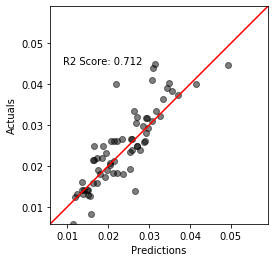

In [86]:
cnss_func.model_analyse_pred(X_test_sa3, y_test_sa3, model_sa3)

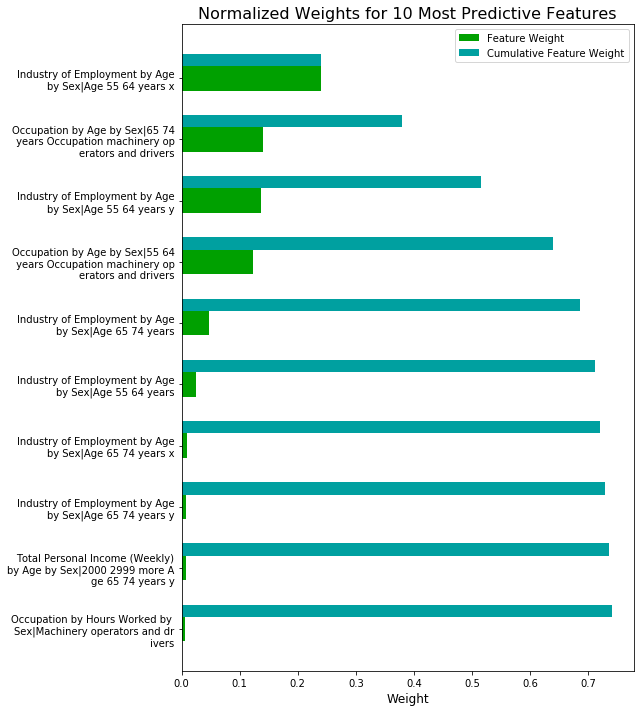

In [87]:
cnss_func.feature_plot_h(model_sa3.steps[1][1], X_train_sa3, 10)

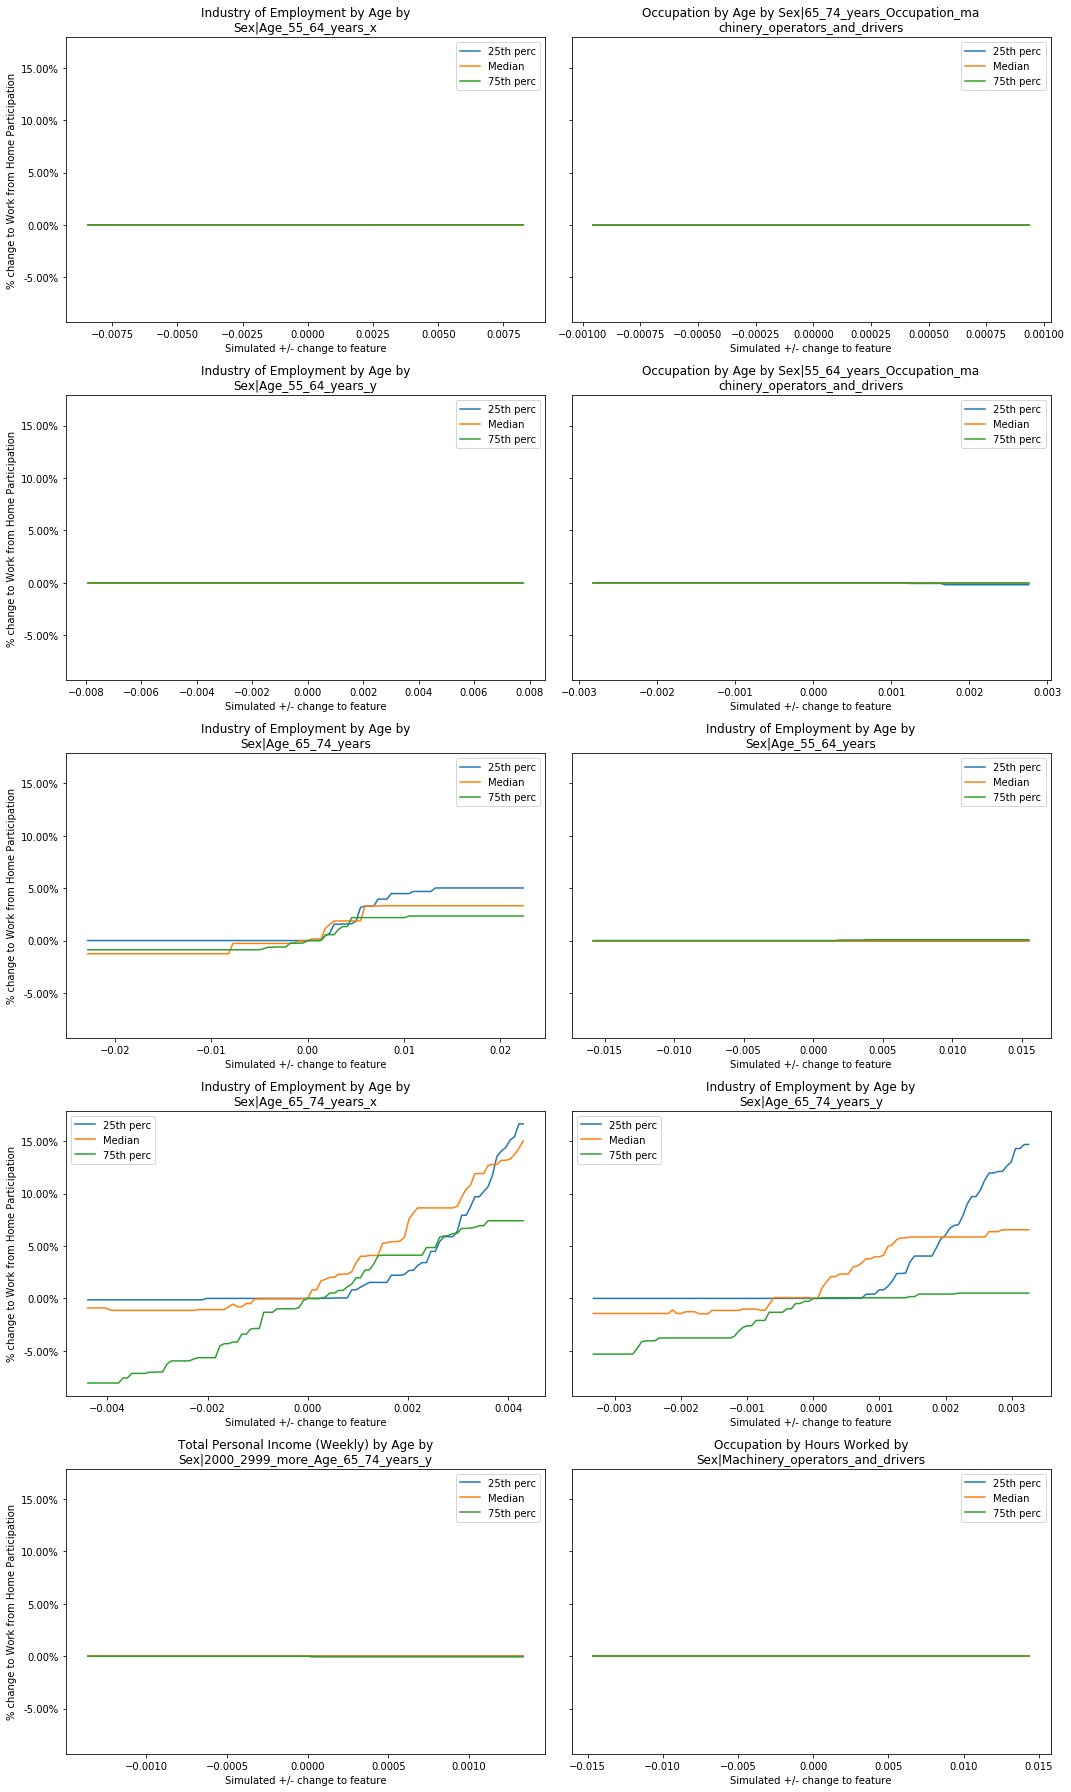

In [82]:
cnss_func.feature_impact_plot(model_sa3.steps[1][1], X_train_sa3, 10, 'Work from Home Participation', model_sa3)

model_sa2, X_train_sa2, X_test_sa2, y_train_sa2, y_test_sa2, X_sa2 = model_WFH('SA2')

X_train_sa2.to_csv('{}\Saved data\X_train_sa2.csv'.format(nb_path))
X_test_sa2.to_csv('{}\Saved data\X_test_sa2.csv'.format(nb_path))
y_train_sa2.to_csv('{}\Saved data\y_train_sa2.csv'.format(nb_path))
y_test_sa2.to_csv('{}\Saved data\y_test_sa2.csv'.format(nb_path))
X_sa2.to_csv('{}\Saved data\X_sa2.csv'.format(nb_path))
pickle.dump(model_sa2, open('{}\Saved data\model_sa2.pkl'.format(nb_path), 'wb'))

In [65]:
X_train_sa2 = pd.read_csv('{}\Saved data\X_train_sa2.csv'.format(nb_path))
X_test_sa2 = pd.read_csv('{}\Saved data\X_test_sa2.csv'.format(nb_path))
y_train_sa2 = pd.read_csv('{}\Saved data\y_train_sa2.csv'.format(nb_path), header=None)
y_test_sa2 = pd.read_csv('{}\Saved data\y_test_sa2.csv'.format(nb_path), header=None)
X_sa2 = pd.read_csv('{}\Saved data\X_sa2.csv'.format(nb_path))
X_train_sa2 = X_train_sa2.set_index(X_train_sa2.columns[0])
X_test_sa2 = X_test_sa2.set_index(X_test_sa2.columns[0])
y_train_sa2 = y_train_sa2.set_index(y_train_sa2.columns[0])
y_test_sa2 = y_test_sa2.set_index(y_test_sa2.columns[0])

In [61]:
with open('{}\Saved data\model_sa2.pkl'.format(nb_path), 'rb') as f:
    model_sa2 = pickle.load(f)

In [66]:
y_test_sa2 = pd.Series(y_test_sa2.iloc[:,0])

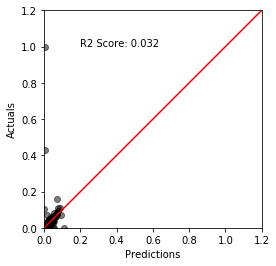

In [67]:
cnss_func.model_analyse_pred(X_test_sa2, y_test_sa2, model_sa2)

In [68]:
y_test_sa2.sort_values(ascending=False).head()

0
801101137    1.000000
801101134    0.428571
205051099    0.160000
315011397    0.107241
215011393    0.106768
Name: 1, dtype: float64

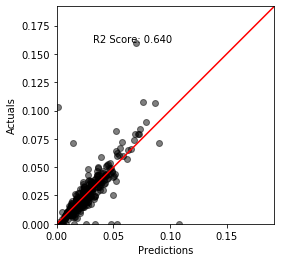

In [69]:
cnss_func.model_analyse_pred(X_test_sa2.drop([801101137,801101134]), y_test_sa2.drop([801101137,801101134]), model_sa2)

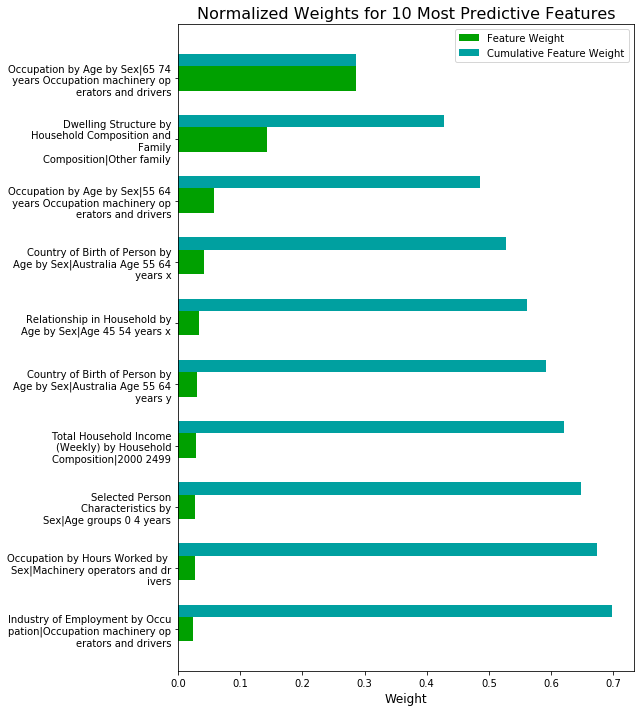

In [78]:
cnss_func.feature_plot_h(model_sa2.steps[1][1], X_train_sa2, 10)

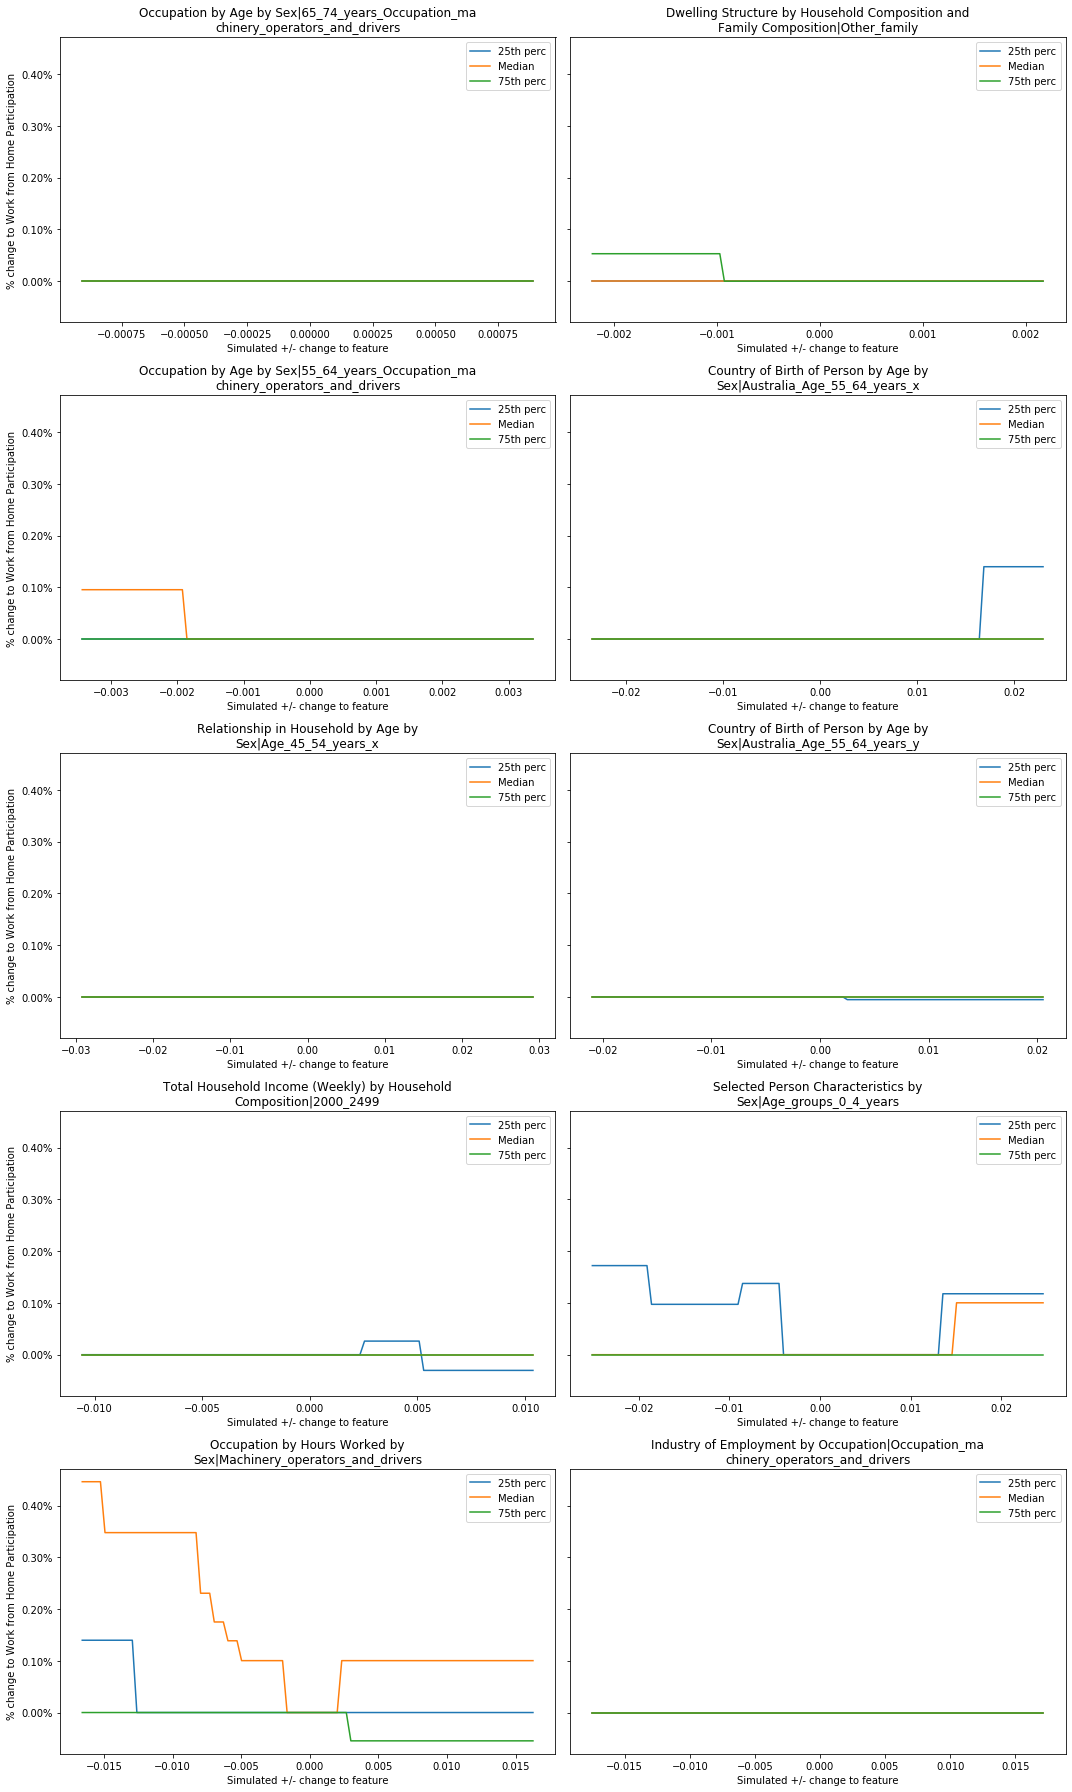

In [80]:
cnss_func.feature_impact_plot(model_sa2.steps[1][1], X_train_sa2, 10, 'Work from Home Participation', model_sa2)

### Notes on SA2 data
There are clearly some large outliers in this dataset that needs understanding. A WFH ratio of "1" is incredibly rare so it is unsurprising that it is first of all not predictable, and it is having a significant impact on the overall accuracy metric.

Let's look at SA1 data, then come back to SA2.

model_sa1, X_train_sa1, X_test_sa1, y_train_sa1, y_test_sa1, X_sa1 = model_WFH('SA1')

X_train_sa1.to_csv('{}\Saved data\X_train_sa1.csv'.format(nb_path))
X_test_sa1.to_csv('{}\Saved data\X_test_sa1.csv'.format(nb_path))
y_train_sa1.to_csv('{}\Saved data\y_train_sa1.csv'.format(nb_path))
y_test_sa1.to_csv('{}\Saved data\y_test_sa1.csv'.format(nb_path))
X_sa1.to_csv('{}\Saved data\X_sa1.csv'.format(nb_path))

pickle.dump(model_sa1, open('{}\Saved data\model_sa1.pkl'.format(nb_path), 'wb'))

In [71]:
X_train_sa1 = pd.read_csv('{}\Saved data\X_train_sa1.csv'.format(nb_path))
X_test_sa1 = pd.read_csv('{}\Saved data\X_test_sa1.csv'.format(nb_path))
y_train_sa1 = pd.read_csv('{}\Saved data\y_train_sa1.csv'.format(nb_path), header=None)
y_test_sa1 = pd.read_csv('{}\Saved data\y_test_sa1.csv'.format(nb_path), header=None)
X_sa1 = pd.read_csv('{}\Saved data\X_sa1.csv'.format(nb_path))
X_train_sa1 = X_train_sa1.set_index(X_train_sa1.columns[0])
X_test_sa1 = X_test_sa1.set_index(X_test_sa1.columns[0])
y_train_sa1 = y_train_sa1.set_index(y_train_sa1.columns[0])
y_test_sa1 = y_test_sa1.set_index(y_test_sa1.columns[0])

In [72]:
with open('{}\Saved data\model_sa1.pkl'.format(nb_path), 'rb') as f:
    model_sa1 = pickle.load(f)

In [73]:
y_test_sa1 = pd.Series(y_test_sa1.iloc[:,0])

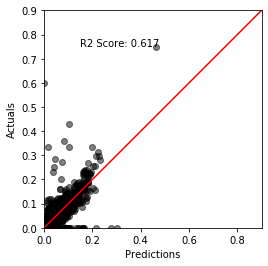

In [74]:
cnss_func.model_analyse_pred(X_test_sa1, y_test_sa1, model_sa1)

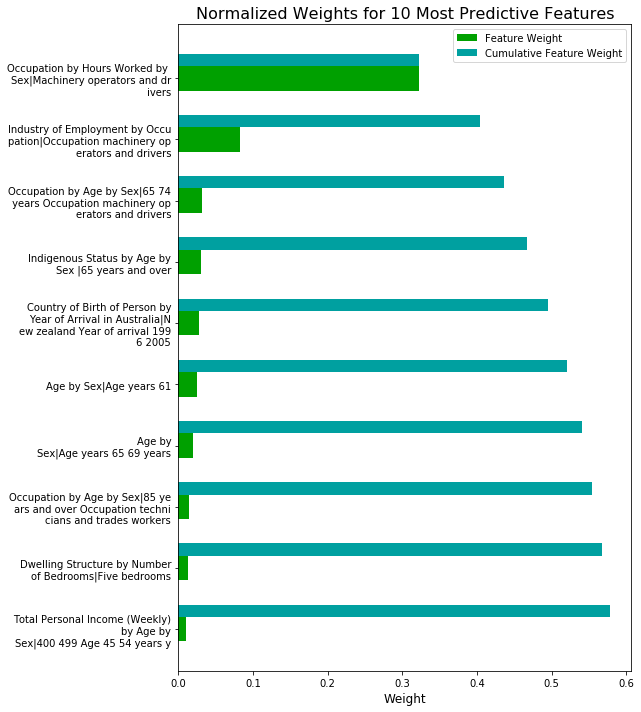

In [75]:
cnss_func.feature_plot_h(model_sa1.steps[1][1], X_train_sa1, 10)

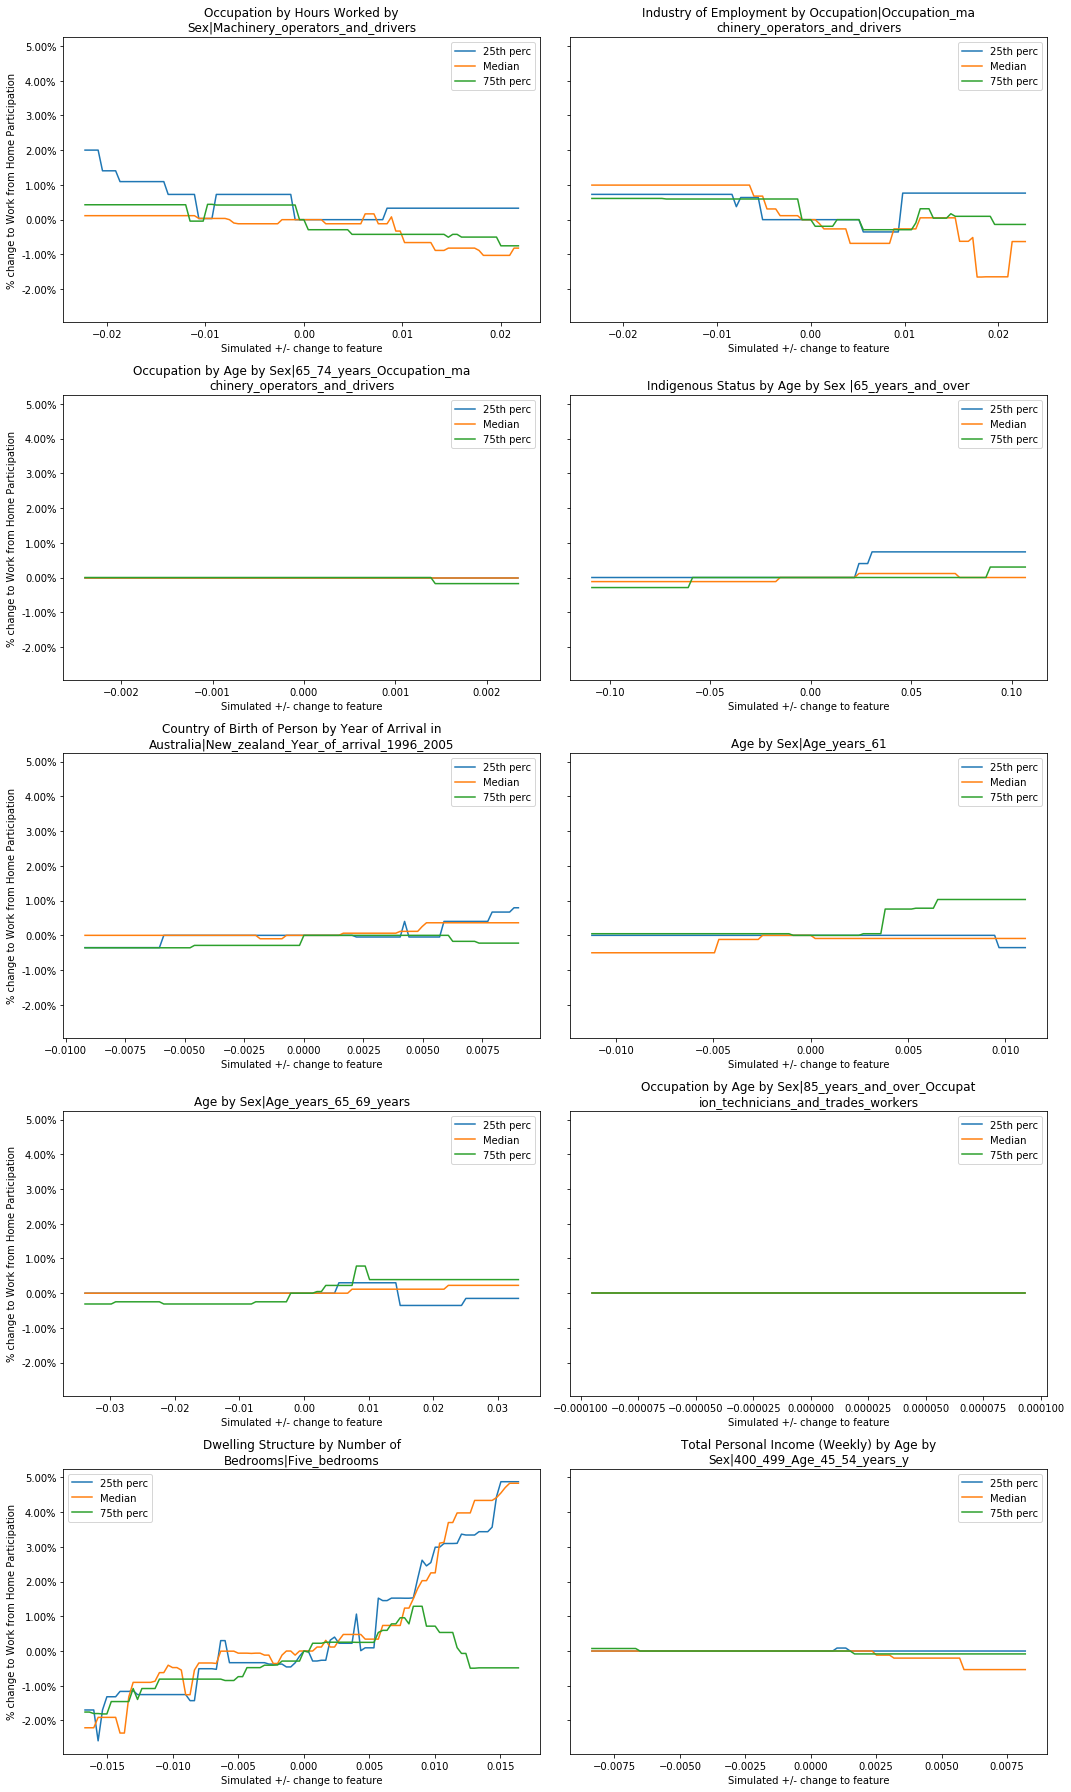

In [76]:
cnss_func.feature_impact_plot(model_sa1.steps[1][1], X_train_sa1, 10, 'Work from Home Participation', model_sa1)

### Reflections on SA1 Data
After working through a large amount of bugs in my initial workings, it appears the outcome is consistent with my initial hypothesis, but in a different (albeit still intuitive) way. Model performance does indeed deteriorate as detail gets more granular, but it appears this is largely attributable to a higher level of variance in the underlying data making it more difficult to predict. Whereas at an SA3 level it was incredibly unlikely to get a participation rate greater than 5%, at an SA1 or even occaisionally SA2 level there are instances of up to 100% participation in working from home! (My assumption based on a brief look at the actual locations is that this represents a few farmers).

## Comparisons
Below I will investigate and compare the factor importances between the models, the impacts of reducing the number of factors (given roughly 2000 variables, a 90% reduction may be interesting), as well as changing some of the category types we are bringing in in the first instance and seeing the impact on model performance (e.g. removing "Age" and its proxies, and bringing in "sex"). For starters regarding reducing characteristics, there seems to be a lot of overlap in some of the fields, which is just creating unnecessary noise in the feature importances (e.g. including both summary 'Age' as well as 'Occupation by age'), so I will first strip this list down, and then strip down the list by feature importances.

I also noticed above that while the pipeline *should* remove duplicate columns, a few are slipping through that are basically the same but only slightly different (e.g. the "Hours works" and "Industry of employment" lines are almost identical except for just enough cases for them not to be filtered out in the pipeline). Accordingly I am going to pick out a more careful selection of tables to load.

Note in this section I have also updated the model_WFH function to remove outliers automatically.

In [88]:
# Show tables which have the above fields of information available
df_meta = pd.read_csv('{}\Data\Metadata\Metadata_2016_refined.csv'.format(nb_path))
df_m_refined = df_meta[(df_meta['Age'] > 0) |
                      (df_meta['Income'] > 0) |
                      (df_meta['Occupation'] > 0) |
                      (df_meta['Family Composition'] > 0) |
                      (df_meta['Internet status'] > 0) |
                      (df_meta['Building occupation status'] > 0) |
                      (df_meta['Number of Bedrooms'] > 0) |
                      (df_meta['Place of Birth'] > 0) |
                      (df_meta['Country of Birth of Parents'] > 0) |
                      (df_meta['Year of Arrival'] > 0)]
for row in df_m_refined[['DataPack file','Table name']].drop_duplicates().iterrows():
    print(row)

(3, DataPack file                                       G01
Table name       Selected Person Characteristics by Sex
Name: 3, dtype: object)
(116, DataPack file                                                G03
Table name       Place of Usual Residence on Census Night by Age
Name: 116, dtype: object)
(256, DataPack file          G04A
Table name       Age by Sex
Name: 256, dtype: object)
(456, DataPack file          G04B
Table name       Age by Sex
Name: 456, dtype: object)
(562, DataPack file                                        G05
Table name       Registered Marital Status by Age by Sex
Name: 562, dtype: object)
(742, DataPack file                                    G06
Table name       Social Marital Status by Age by Sex
Name: 742, dtype: object)
(862, DataPack file                                 G07
Table name       Indigenous Status by Age by Sex 
Name: 862, dtype: object)
(1240, DataPack file                                        G09A
Table name       Country of Birth of Pers

In [108]:
# Hand pick the tables to load
tables_to_load = ['G57','G55','G37','G33','G34','G09']
load_tables = tables_to_load
# Dropping year of arrival and 'country of birth of parents
# as it rarely appeared in top features and when it did was mostly a proxy for age
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

In [110]:
model_sa3_ref, X_train_sa3_ref, X_test_sa3_ref, y_train_sa3_ref, y_test_sa3_ref = cnss_func.model_WFH('SA3',load_tables,
                                                                                                      load_features)

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.744, total=   0.3s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.746, total=   0.3s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.768, total=   0.3s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.744, total=   0.6s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.741, total=   0.7s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.787, total=   0.7s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.744, total=   0.3s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.746, total=   0.3s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.768, total=   0.3s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    8.7s finished


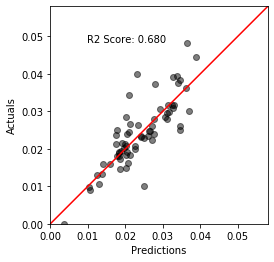

In [111]:
cnss_func.model_analyse_pred(X_test_sa3_ref, y_test_sa3_ref, model_sa3_ref)

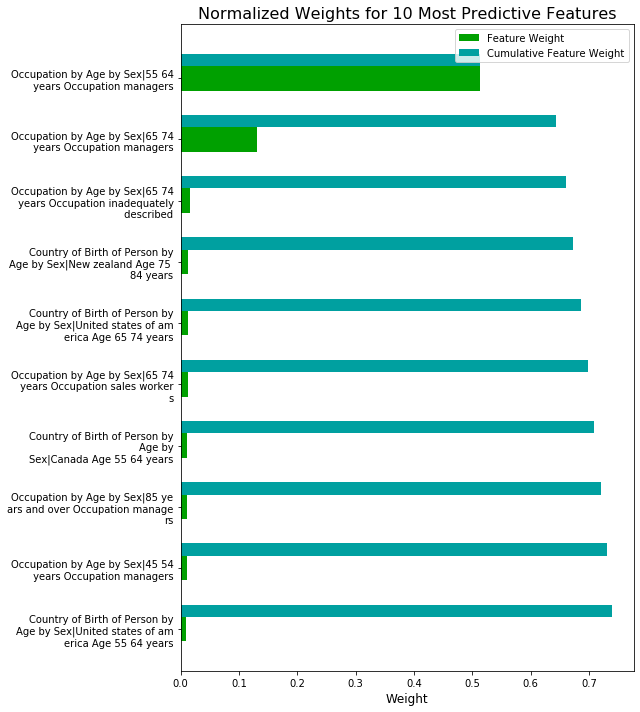

In [112]:
cnss_func.feature_plot_h(model_sa3_ref.steps[1][1], X_train_sa3_ref, 10)

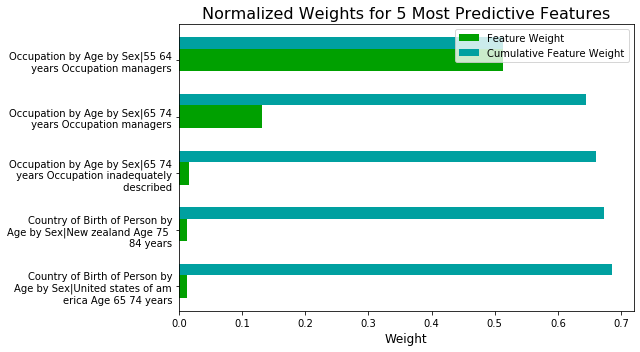

In [113]:
cnss_func.feature_plot_h(model_sa3_ref.steps[1][1], X_train_sa3_ref, 5)

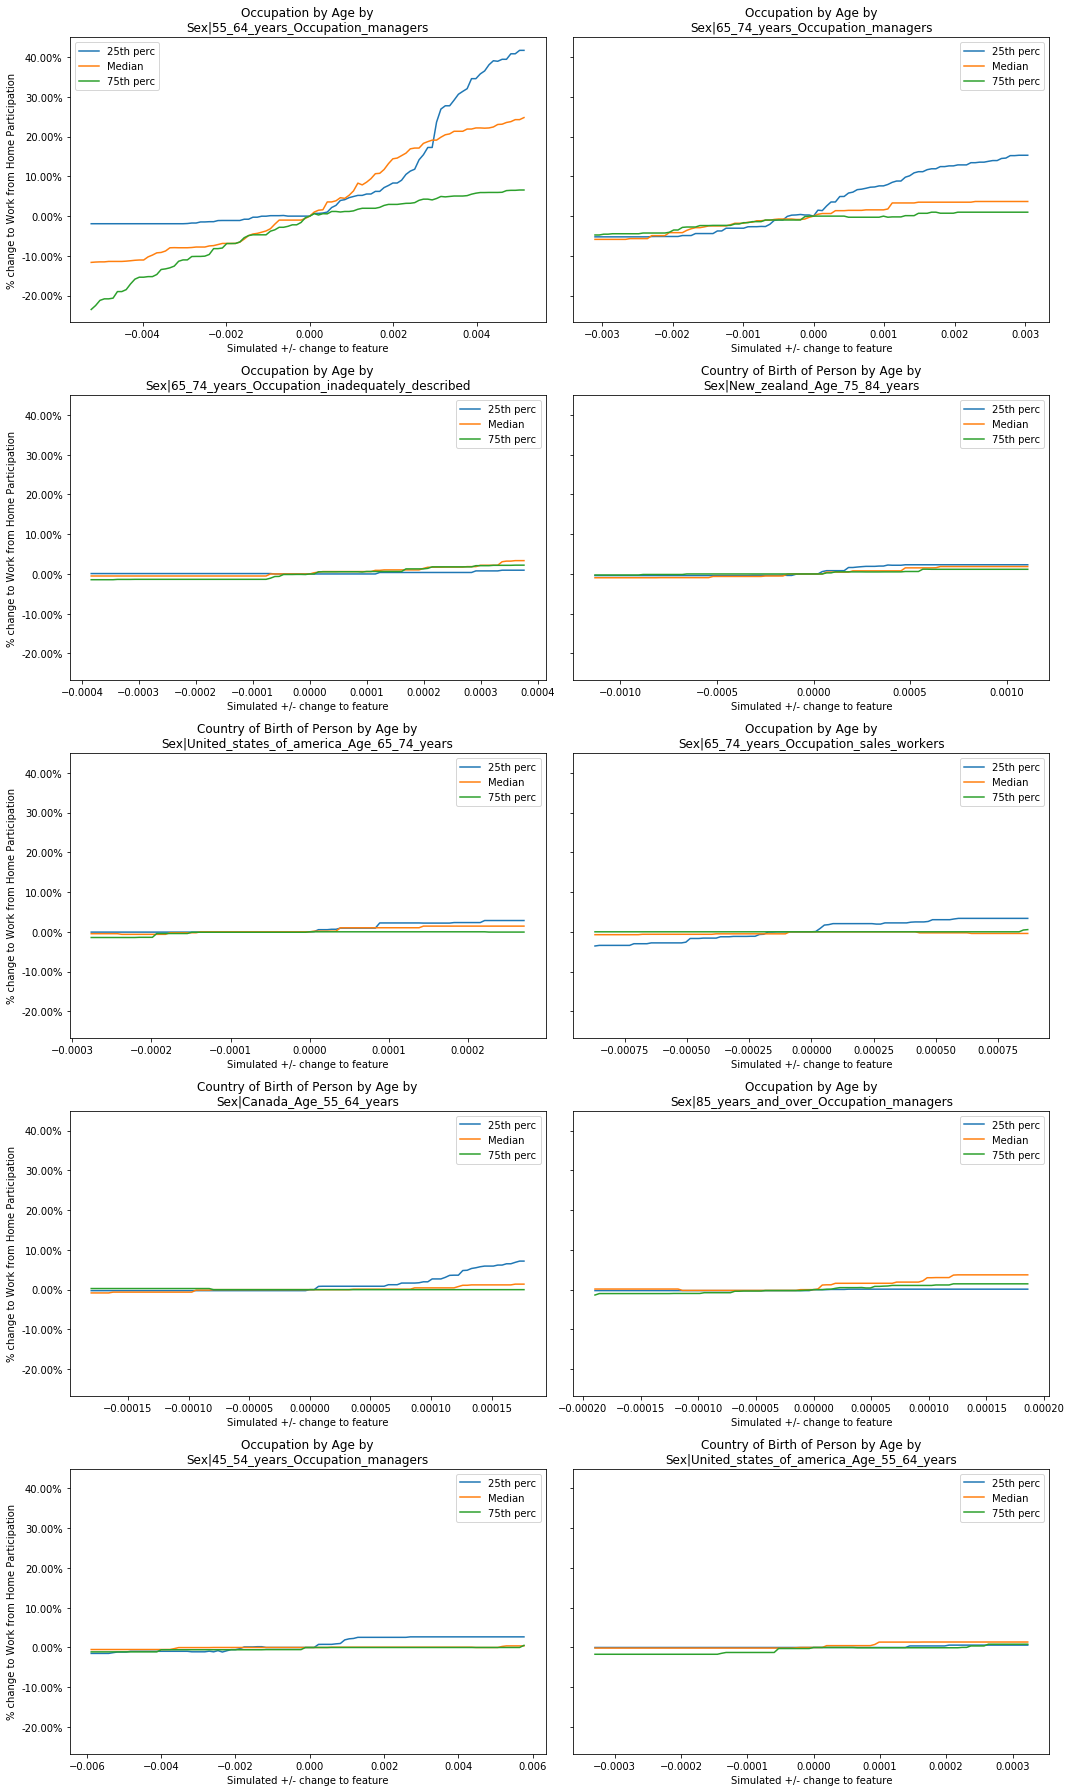

In [114]:
cnss_func.feature_impact_plot(model_sa3_ref.steps[1][1], X_train_sa3_ref, 10, 'Work from Home Participation', model_sa3_ref)

In [115]:
# Reduce feature count to top 100
top_100_feats = cnss_func.top_n_features(model_sa3_ref.steps[1][1], X_train_sa3_ref, 100)
# Create X & y
X_sa3_ref = X_train_sa3_ref.append(X_test_sa3_ref)
X_sa3_100 = X_sa3_ref[top_100_feats]
y_sa3 = y_train_sa3_ref.append(y_test_sa3_ref)

zero_indicies_drop = set(y_sa3.index.values) - set(X_sa3_100.index.values.tolist())
y_sa3 = y_sa3.drop(zero_indicies_drop, axis=0)

# Split the 'features' and 'response' vectors into training and testing sets
X_train_sa3_100, X_test_sa3_100, y_train_sa3_100, y_test_sa3_100 = train_test_split(X_sa3_100, 
                                                                                    y_sa3, 
                                                                                    test_size = 0.2, 
                                                                                    random_state = 52)

# build a model using all the above inputs
grid_obj_sa3_100 = build_model()

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_sa3_100 = grid_obj_sa3_100.fit(X_train_sa3_100, y_train_sa3_100)
model_sa3_100 = grid_fit_sa3_100.best_estimator_

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.733, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.774, total=   0.1s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s



[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.703, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.754, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.810, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.692, total=   0.2s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.733, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.774, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.703

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.3s finished


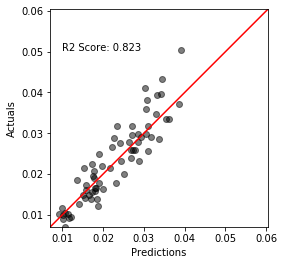

In [116]:
cnss_func.model_analyse_pred(X_test_sa3_100, y_test_sa3_100, model_sa3_100)

Hey we hit the 0.7 R2 score benchmark I set myself at the start!

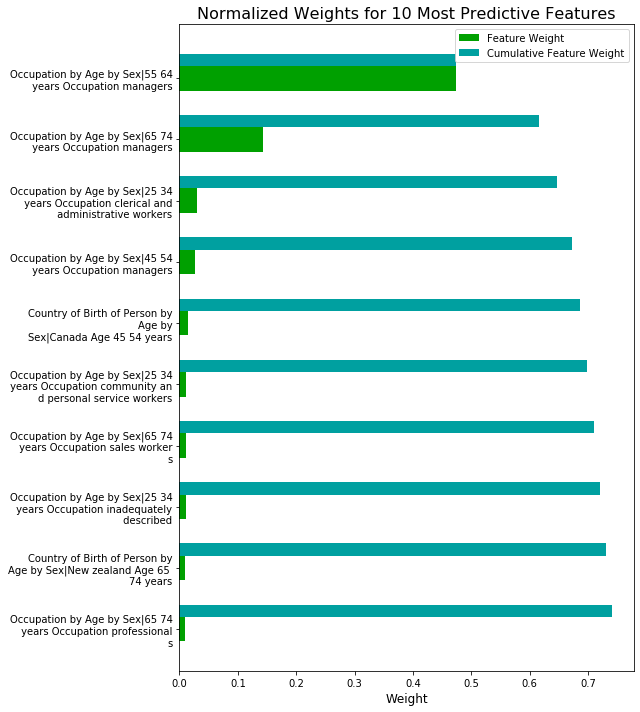

In [117]:
cnss_func.feature_plot_h(model_sa3_100.steps[1][1], X_train_sa3_100, 10)

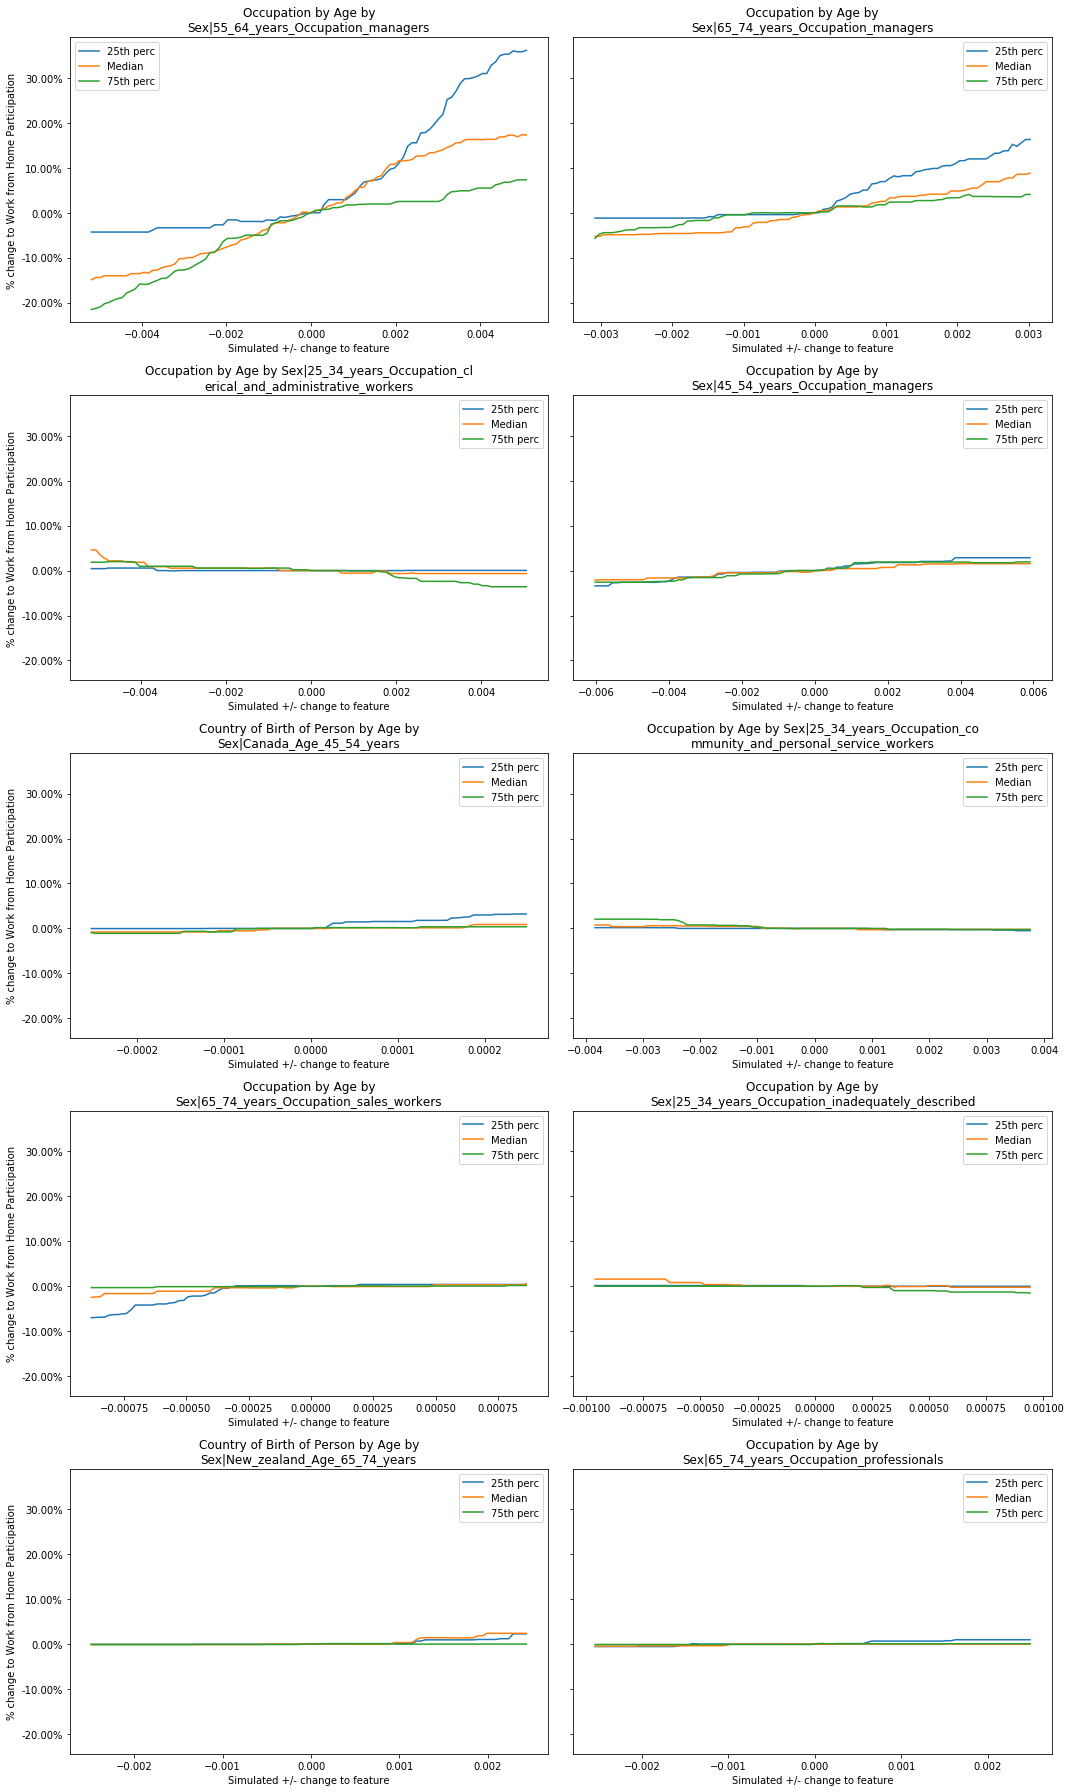

In [118]:
cnss_func.feature_impact_plot(model_sa3_100.steps[1][1], 
                              X_train_sa3_100, 10, 'Work from Home Participation', model_sa3_100)

#### Similar approach for SA2

In [119]:
# Hand pick the tables to load
# Dropping year of arrival and 'country of birth of parents
# as it rarely appeared in top features and when it did was mostly a proxy for age
tables_to_load = ['G57','G55','G37','G33','G34','G09']
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

# Save all the components as reference files so I can quickly refer to these again in the future 
# rather than re-training from scratch
model_sa2_ref, X_train_sa2_ref, X_test_sa2_ref, y_train_sa2_ref, y_test_sa2_ref = cnss_func.model_WFH('SA2',load_tables,
                                                                                                      load_features)

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.780, total=   3.0s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.648, total=   2.9s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.801, total=   2.9s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.762, total=   5.7s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.671, total=   5.4s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.816, total=   5.8s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.771, total=   3.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.652, total=   2.9s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.799, total=   3.2s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.3min finished


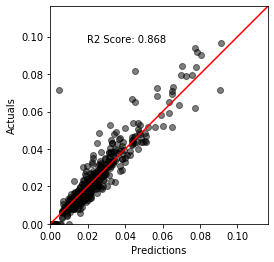

In [120]:
model_analyse_pred(X_test_sa2_ref, y_test_sa2_ref, model_sa2_ref)

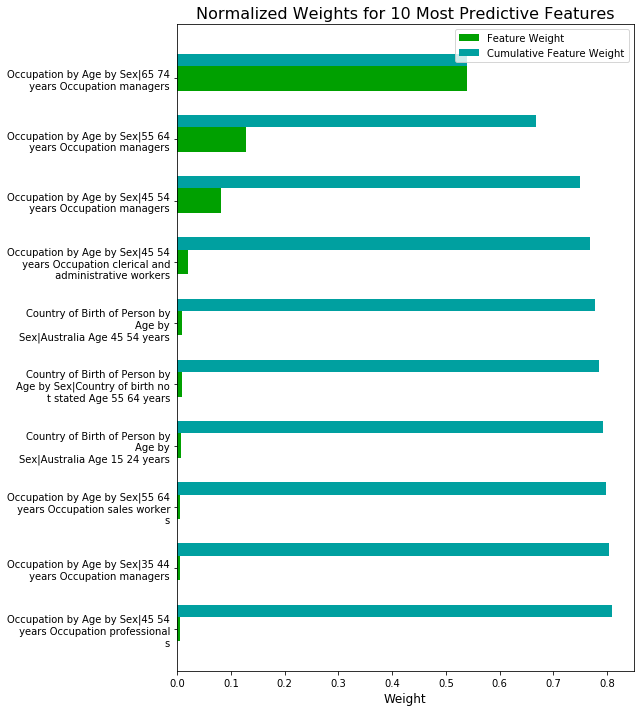

In [121]:
cnss_func.feature_plot_h(model_sa2_ref.steps[1][1], X_train_sa2_ref, 10)

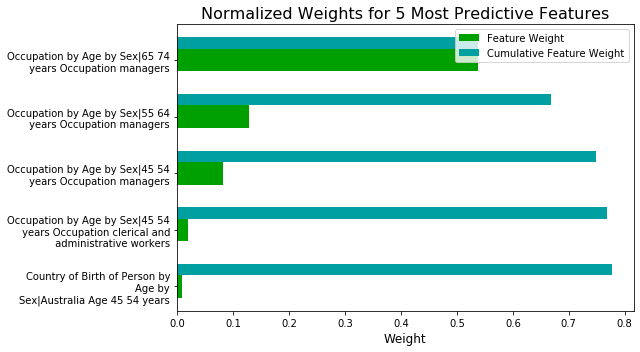

In [122]:
cnss_func.feature_plot_h(model_sa2_ref.steps[1][1], X_train_sa2_ref, 5)

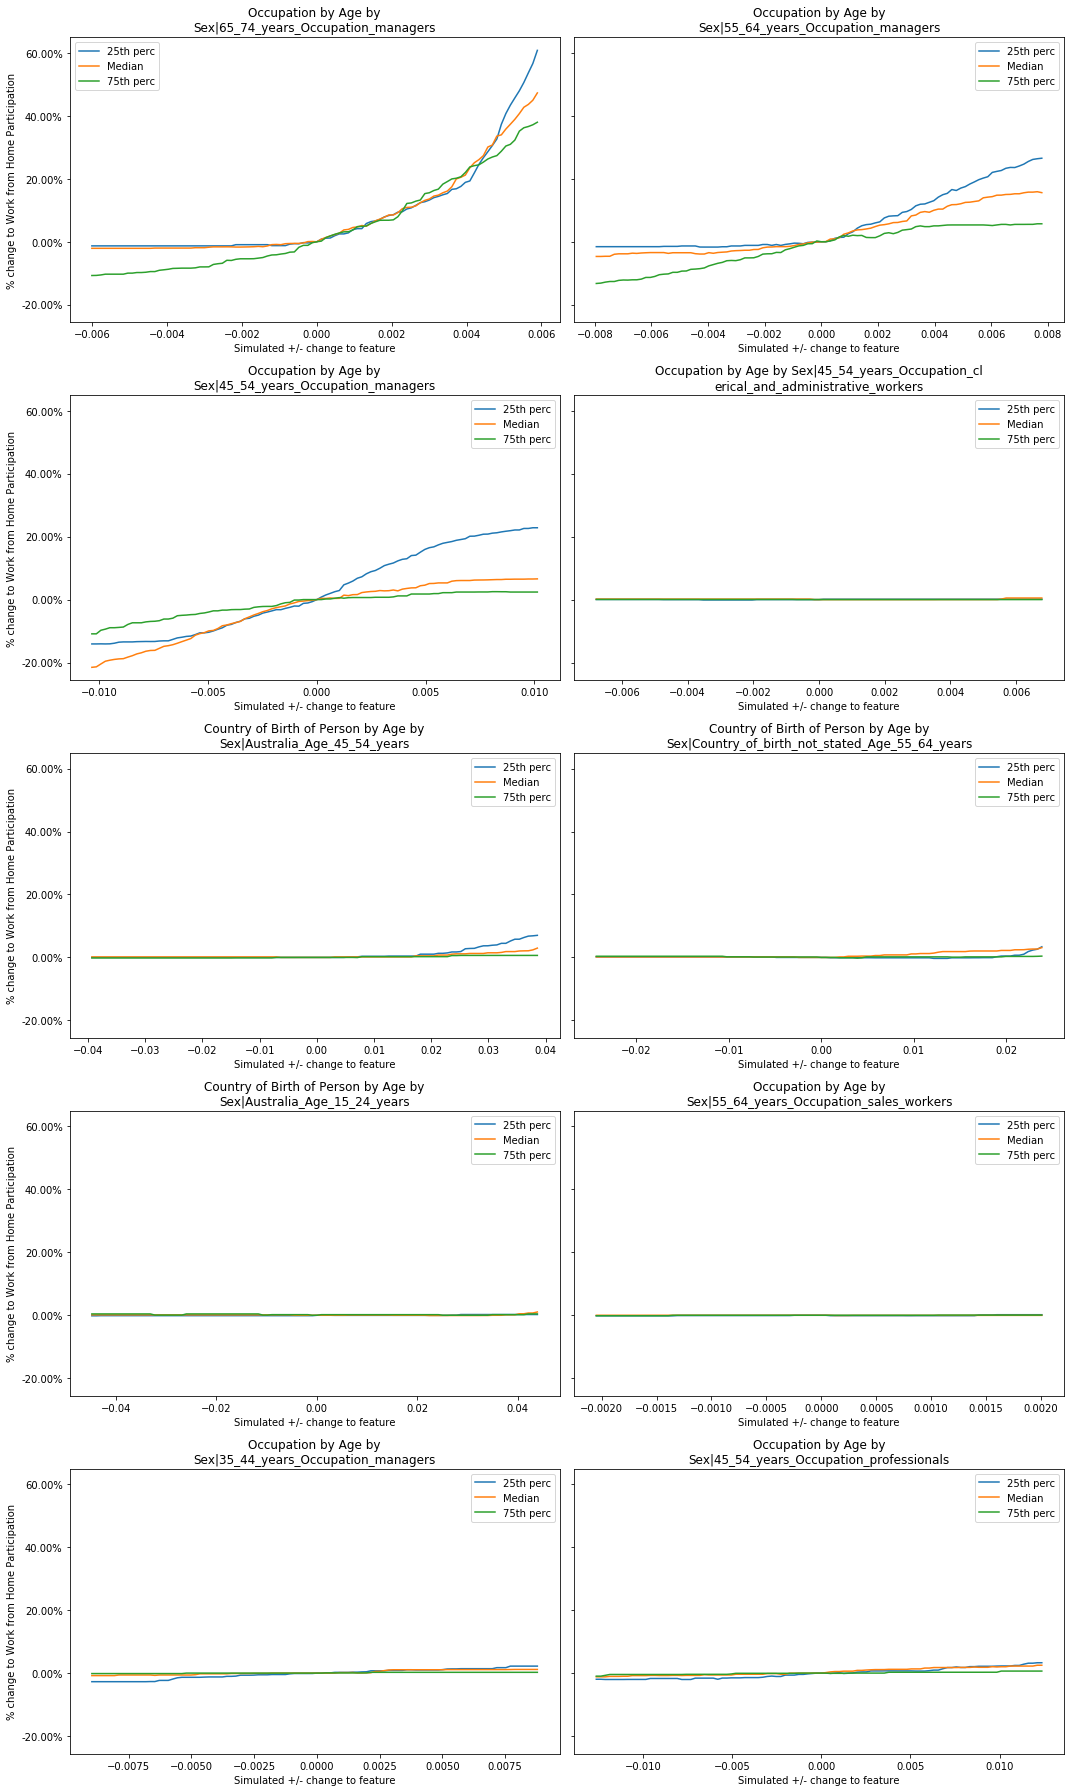

In [123]:
cnss_func.feature_impact_plot(model_sa2_ref.steps[1][1], X_train_sa2_ref, 10, 'Work from Home Participation', model_sa2_ref)

In [124]:
# Reduce feature count to top 100
top_100_feats = cnss_func.top_n_features(model_sa2_ref.steps[1][1], X_train_sa2_ref, 100)

In [125]:
# Create X & y
X_sa2_ref = X_train_sa2_ref.append(X_test_sa2_ref)
X_sa2_100 = X_sa2_ref[top_100_feats]
y_sa2 = y_train_sa2_ref.append(y_test_sa2_ref)

zero_indicies_drop = set(y_sa2.index.values) - set(X_sa2_100.index.values.tolist())
y_sa2 = y_sa2.drop(zero_indicies_drop, axis=0)

# Split the 'features' and 'response' vectors into training and testing sets
X_train_sa2_100, X_test_sa2_100, y_train_sa2_100, y_test_sa2_100 = train_test_split(X_sa2_100, 
                                                                                    y_sa2, 
                                                                                    test_size = 0.2, 
                                                                                    random_state = 52)

# build a model using all the above inputs
grid_obj_sa2_100 = build_model()

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_sa2_100 = grid_obj_sa2_100.fit(X_train_sa2_100, y_train_sa2_100)
model_sa2_100 = grid_fit_sa2_100.best_estimator_

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.851, total=   0.9s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.730, total=   0.9s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.772, total=   0.8s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.851, total=   1.7s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.729, total=   1.7s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.774, total=   1.8s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.846, total=   0.9s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.732, total=   0.9s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.770, total=   0.9s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   23.6s finished


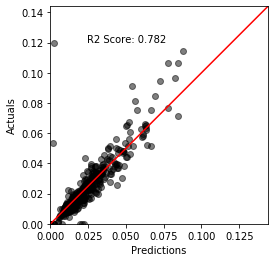

In [126]:
model_analyse_pred(X_test_sa2_100, y_test_sa2_100, model_sa2_100)

Strange that this decreased performance while the refinement at the SA3 level increased.

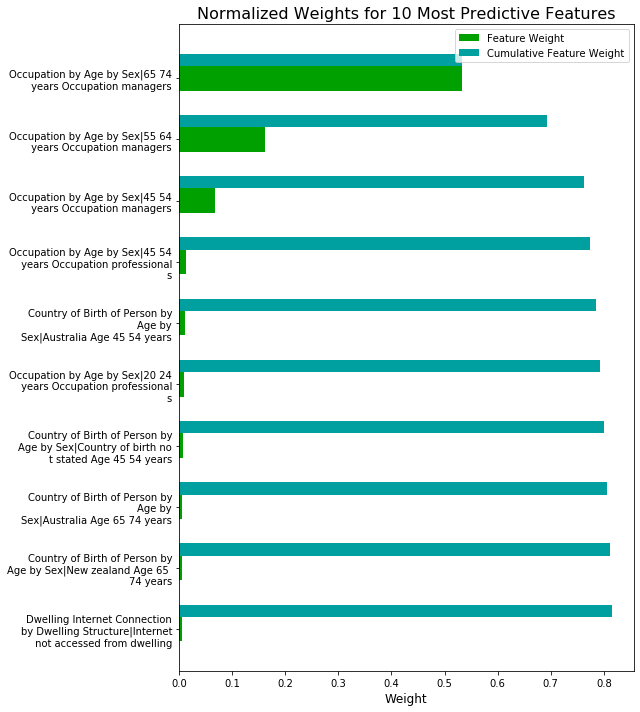

In [130]:
cnss_func.feature_plot_h(model_sa2_100.steps[1][1], X_train_sa2_100, 10)

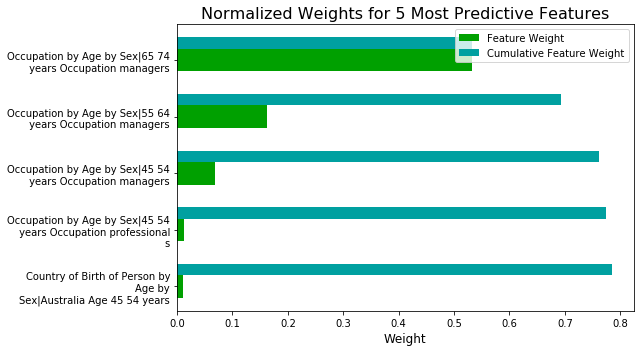

In [131]:
cnss_func.feature_plot_h(model_sa2_100.steps[1][1], X_train_sa2_100, 5)

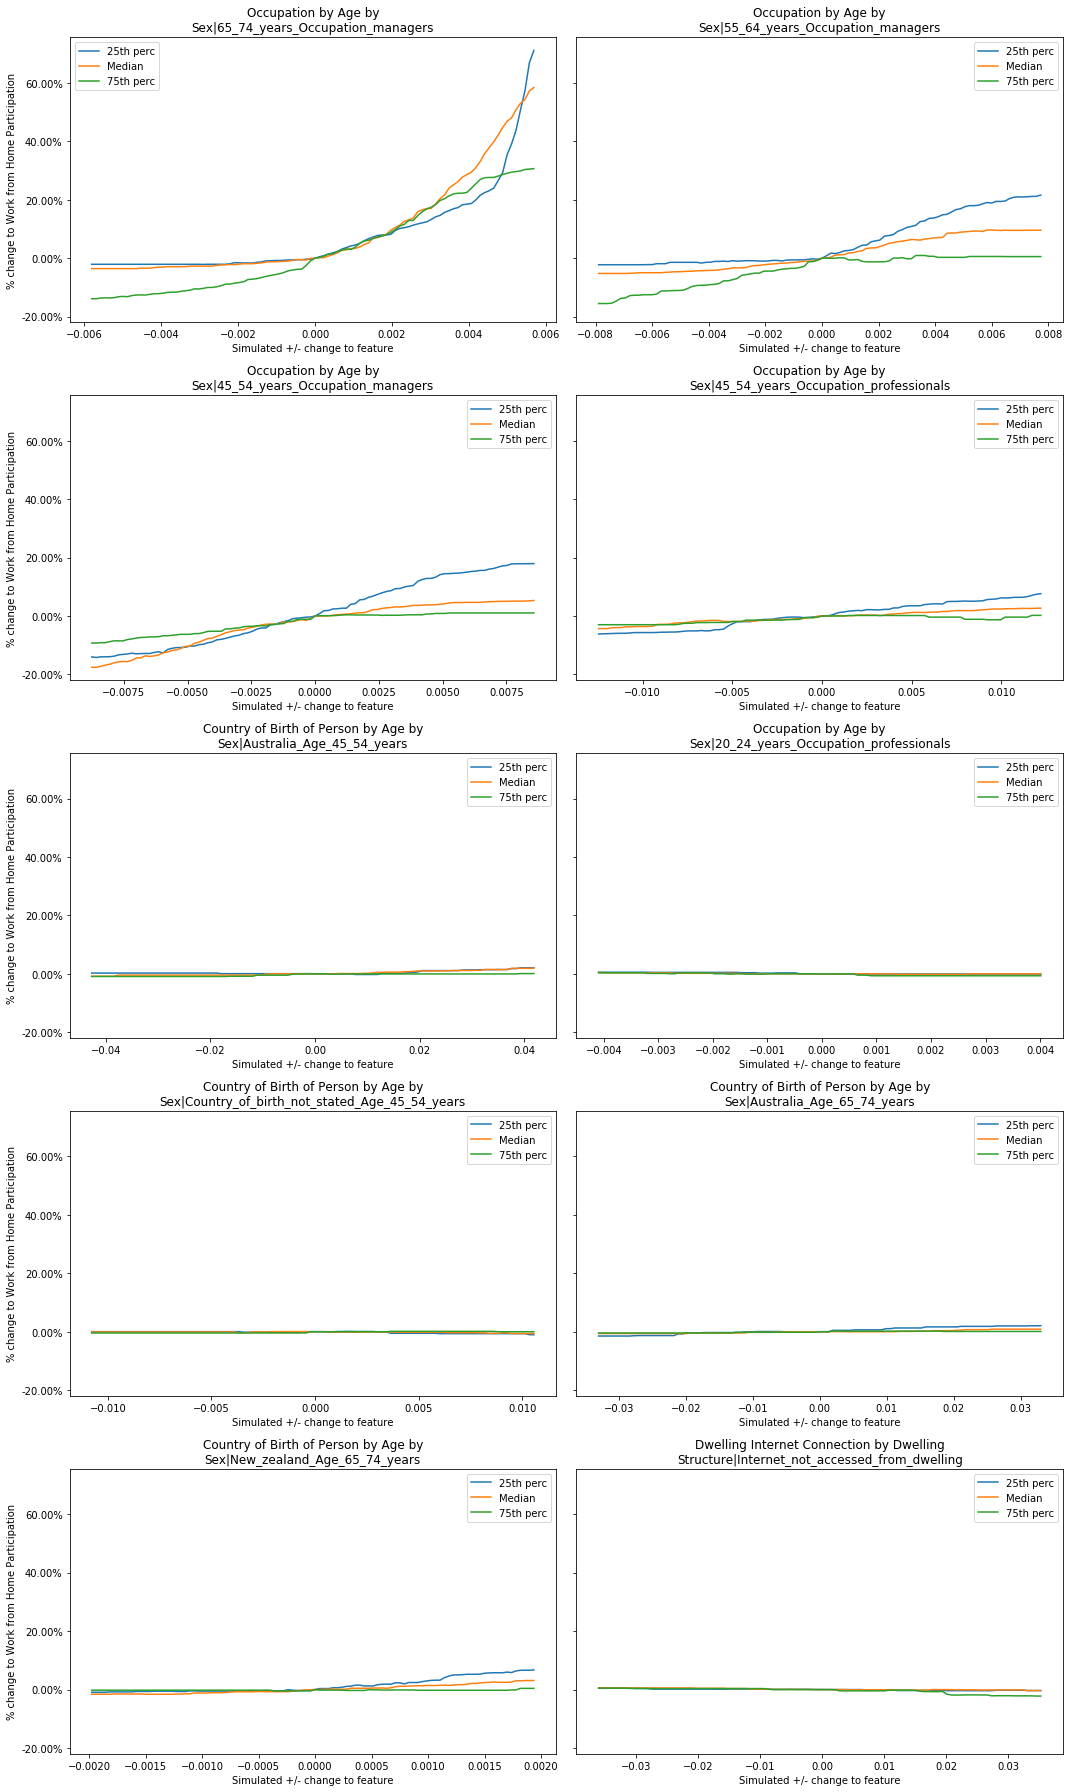

In [132]:
cnss_func.feature_impact_plot(model_sa2_100.steps[1][1], 
                              X_train_sa2_100, 10, 'Work from Home Participation', model_sa2_100)

### Repeat at SA1 level
Cut to the chase and refine the key features before plotting everything this time.

In [2]:
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']
# Save all the components as reference files so I can quickly refer to these again in the future 
# rather than re-training from scratch
model_sa1_ref, X_train_sa1_ref, X_test_sa1_ref, y_train_sa1_ref, y_test_sa1_ref = cnss_func.model_WFH('SA1',load_tables,
                                                                                                      load_features)

# Reduce feature count to top 100
top_100_feats = cnss_func.top_n_features(model_sa1_ref.steps[1][1], X_train_sa1_ref, 100)
# Create X & y
X_sa1_ref = X_train_sa1_ref.append(X_test_sa1_ref)
X_sa1_100 = X_sa1_ref[top_100_feats]
y_sa1 = y_train_sa1_ref.append(y_test_sa1_ref)

zero_indicies_drop = set(y_sa1.index.values) - set(X_sa1_100.index.values.tolist())
y_sa1 = y_sa1.drop(zero_indicies_drop, axis=0)

# Split the 'features' and 'response' vectors into training and testing sets
X_train_sa1_100, X_test_sa1_100, y_train_sa1_100, y_test_sa1_100 = train_test_split(X_sa1_100, 
                                                                                    y_sa1, 
                                                                                    test_size = 0.2, 
                                                                                    random_state = 52)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.565, total= 1.0min
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.556, total=  55.8s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.567, total=  53.9s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.576, total= 1.8min
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.566, total= 1.8min
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.578, total= 1.9min
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.563, total= 1.3min
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.554, total= 1.2min
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.566, total= 1.2min
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 31.0min finished


NameError: name 'build_model' is not defined

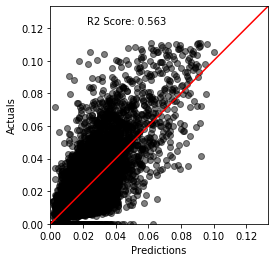

In [3]:
cnss_func.model_analyse_pred(X_test_sa1_ref, y_test_sa1_ref, model_sa1_ref)

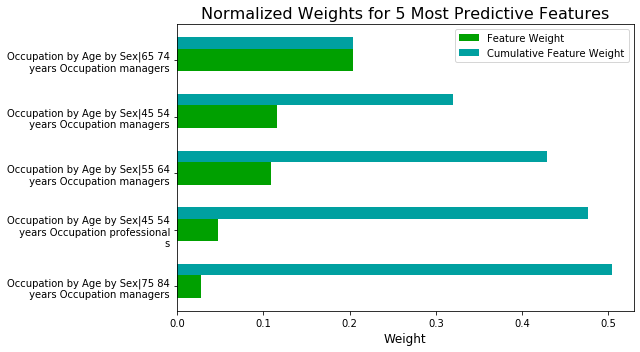

In [9]:
cnss_func.feature_plot_h(model_sa1_ref.steps[1][1], X_train_sa1_ref, 5)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.556, total=  27.7s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.570, total=  28.0s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.6s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.559, total=  28.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.564, total=  55.0s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.580, total=  55.8s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.569, total=  55.0s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.552, total=  33.5s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.569, total=  33.9s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.557, total=  33.3s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 14.4min finished


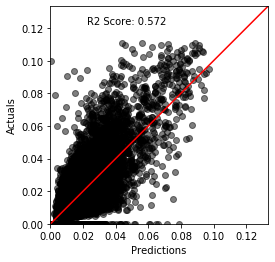

In [6]:
# build a model using all the above inputs
grid_obj_sa1_100 = cnss_func.build_model()

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_sa1_100 = grid_obj_sa1_100.fit(X_train_sa1_100, y_train_sa1_100)
model_sa1_100 = grid_fit_sa1_100.best_estimator_
cnss_func.model_analyse_pred(X_test_sa1_100, y_test_sa1_100, model_sa1_100)

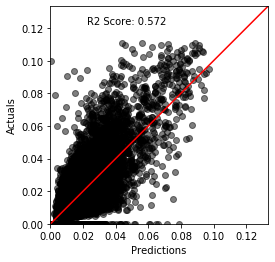

In [7]:
cnss_func.model_analyse_pred(X_test_sa1_100, y_test_sa1_100, model_sa1_100)

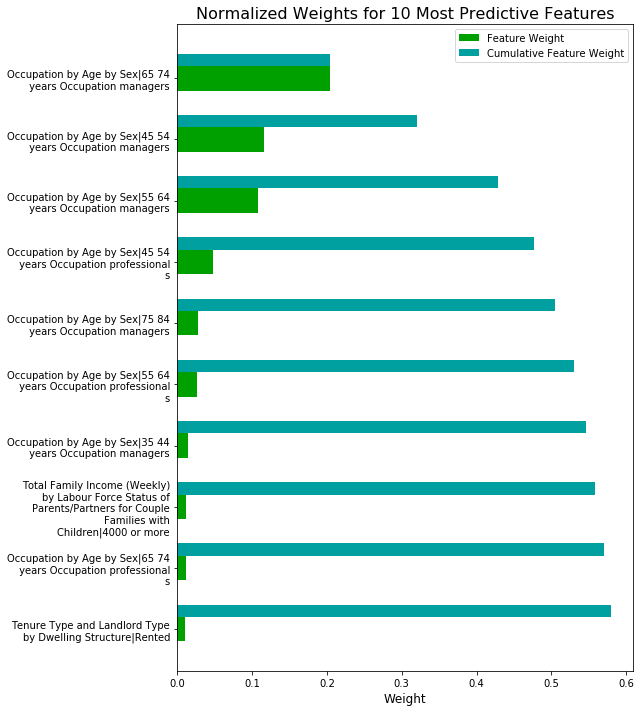

In [8]:
cnss_func.feature_plot_h(model_sa1_ref.steps[1][1], X_train_sa1_ref, 10)

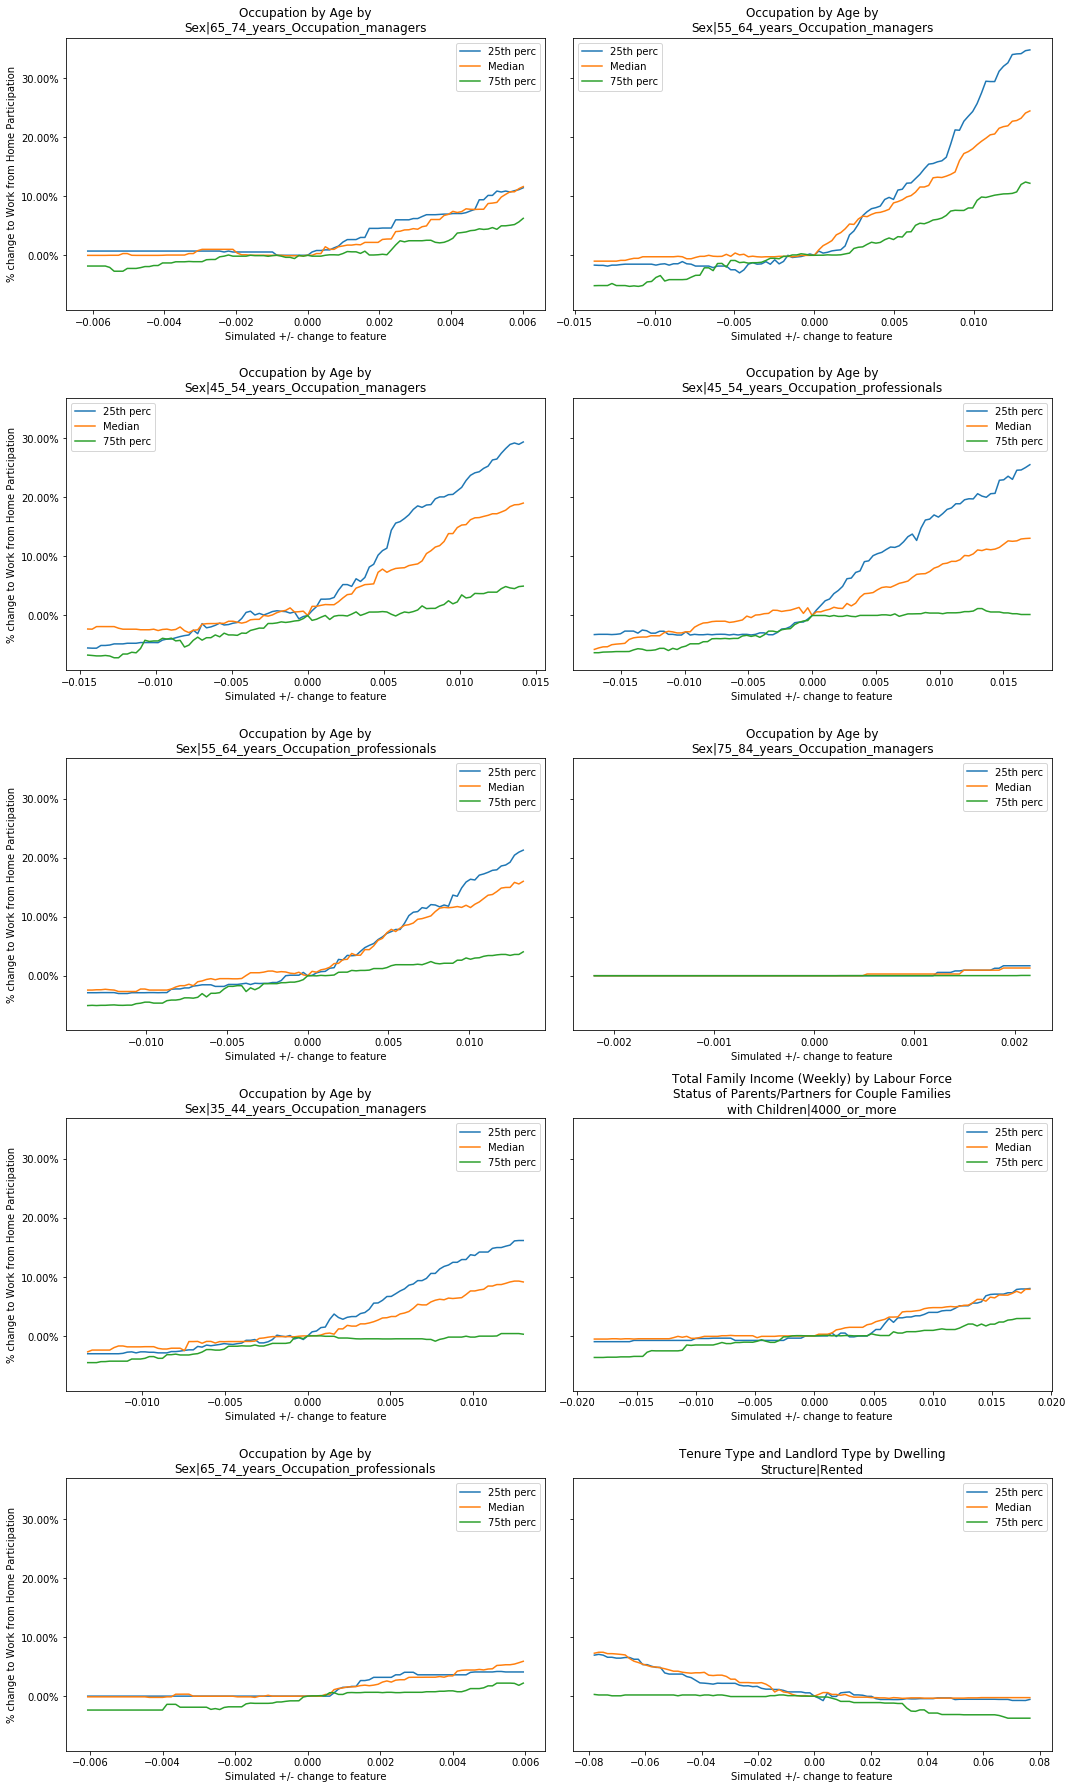

In [10]:
cnss_func.feature_impact_plot(model_sa1_100.steps[1][1], 
                              X_train_sa1_100, 10, 'Work from Home Participation', model_sa1_100)

### What I've learned
Old people love working from home. Or they have more leverage, or some other factor or combination of factors drives an unexpectedly strong response in the Work From Home Participation Rate from the proportion of a given region's population that is >55. 

Really, I'm amazed at just how dominant an Age >55 is as a feature here in terms of its dominance in effect on overall propensity to work from home. From both an SA2 and SA3 level of data, age is the dominant factor in who works from home, especially at the >50 level. So much so that the share of people <45 is also a key feature, having a (slightly) negative correlation even having taken into account the share of the older population! That these factors are more important than the amount of factory line workers in a region or even access to the internet itself is really surprising.

Given the strength of this relationship in the above, I'm curious as to what happens when you remove age from the equation (and also what happens when you add sex in as a feature.

## Drilling down on evaluating model efficacy
In compiling the above analysis, I saw a great deal of fluctuation in the R2 score when changing the random_state seed for the test_train_split. While in general from a limited sample of estimates my observations seemed to conform with my basic hypothesis (that model efficacy improves to a point, then diminishes as greater levels of detail are used as inputs), I'm not completely confident that this is a clear representation of the data.

Having identified the best parameters for the Random Forest model, below I will run an analysis of 200 different train:test model fits at each SA level in order to return a much greater sample of predictions vs actuals to return a more reliable R2 score. 

In [37]:
from tqdm import tqdm

def multi_ttsplit_testing(X, y, filename_path, n_tests = 200):
    '''
    Function for testing multiple test_train_split iterations so come up with an increased sample of 
    predictions vs actuals in order to assess model effectiveness.
    Note: in case of memory issues this writes to an output csv.
    
    INPUTS
    X - pandas dataframe object containing all input variables
    y - pandas series containing the output prediction
    
    OUTPUTS
    filename_loc - path to csv file ready for import into a pandas DF dataframe with two columns, 
                    actuals and predictions, for assessment using metric of choice
    '''
    y_multi_split = pd.DataFrame()
    
    for i in tqdm(range(1,n_tests+1)):
        # Split the 'features' and 'response' vectors into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i)

        # build a model using generally effective hyperparameters noted from above GridSearches
        regr_sa = RandomForestRegressor(n_estimators=40, random_state=42, max_depth=64)

        # Fit the model to the training data
        regr_sa.fit(X_train, y_train)

        y_pred_test = pd.DataFrame(y_test)
        y_pred_test['preds'] = regr_sa.predict(X_test)
        y_pred_test['iteration'] = i

        #output to csv
        if not os.path.isfile(filename_path):
            y_pred_test.to_csv(filename_path, header='column_names')
        else: # else it exists so append without writing the header
            y_pred_test.to_csv(filename_path, mode='a', header=False)
    
    return filename_path

In [38]:
# Dropping year of arrival and country of birth of parents
# as it rarely appeared in top features and when it did was mostly a proxy for age
# Replace Age with Sex based on its much greater effects noted above
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Sex','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

model_sa, X_train, X_test, y_train, y_test = (cnss_func.model_WFH('SA3', load_tables, load_features))
X = X_train.append(X_test)
y = y_train.append(y_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.716, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.800, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.718, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.722, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.789, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.705, total=   0.2s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.716, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.800, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.718,

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.1s finished


In [39]:
filename_path = '{}\SA3_multi_test.csv'.format(nb_path)
SA3_testing_path = multi_ttsplit_testing(X, y, filename_path)
print(SA3_testing_path)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:18<00:00,  2.67it/s]


C:\Users\kempbri\OneDrive - Mars Inc\Documents\GitHub\Census-ASGS-Level-and-Model-Sensitivity\SA3_multi_test.csv


In [40]:
df_sa3_multi_ttest = pd.read_csv('{}\SA3_multi_test.csv'.format(nb_path))

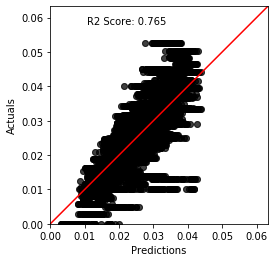

In [41]:
cnss_func.model_analyse(df_sa3_multi_ttest['WFH_Participation'],df_sa3_multi_ttest['preds'])

### SA2 iterative testing

In [168]:
# Dropping year of arrival and country of birth of parents
# as it rarely appeared in top features and when it did was mostly a proxy for age
# Replace Age with Sex based on its much greater effects noted above
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Sex','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

model_sa, X_train, X_test, y_train, y_test = (cnss_func.model_WFH('SA2', load_tables, load_features))
X = X_train.append(X_test)
y = y_train.append(y_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.770, total=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.717, total=   1.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.828, total=   1.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.780, total=   2.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.728, total=   2.0s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.834, total=   2.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.770, total=   1.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.717, total=   1.0s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.826,

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   29.4s finished


In [169]:
filename_path = '{}\SA2_multi_test.csv'.format(nb_path)
SA2_testing_path = multi_ttsplit_testing(X, y, filename_path)
print(SA2_testing_path)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:02<00:00,  3.73s/it]


C:\Users\kempbri\OneDrive - Mars Inc\Documents\GitHub\Census-ASGS-Level-and-Model-Sensitivity\SA2_multi_test.csv


In [170]:
df_sa2_multi_ttest = pd.read_csv('{}\SA2_multi_test.csv'.format(nb_path))

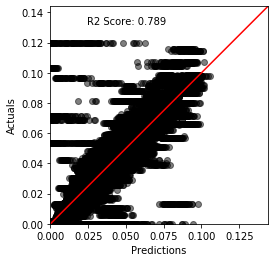

In [186]:
cnss_func.model_analyse(df_sa2_multi_ttest['WFH_Participation'],df_sa2_multi_ttest['preds'])

The above demonstrates a point in line with my initial hypothesis, that SA2 models typically outperform SA3 ones.   
However this choice of 200 iterations is completely arbitrary, and this really should be a case for the implementation on some effective experiment design. Taking the principles of [comparing statistics between populations](https://www.dummies.com/education/math/statistics/how-to-compare-two-independent-population-averages/) I had best quantify the power of this testing procedure under proper statistical hypothesis testing logic where:

$$H_0: R^2_{SA3} - R^2_{SA2} = 0$$


$$H_1: R^2_{SA3} - R^2_{SA2} \neq 0$$

Where $R^2_{SA3}$ and $R^2_{SA2}$ are the r squared values for models trained at the SA3 level and SA2 level, respectively.

From some below [power analysis code sourced from StackOverflow](https://stackoverflow.com/questions/47299824/how-to-calculate-statistical-power-function-vs-sample-size-in-python), it looks like my initial sample of 200 is about what I needed, very lucky!

In [16]:
from statsmodels.stats.power import  tt_ind_solve_power
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def test_ttest_power_diff(mean, std, sample1_size=None, alpha=0.05, desired_power=0.8, mean_diff_percentages=[0.1, 0.05]):
    '''
    calculates the power function for a given mean and std. the function plots a graph showing the comparison between desired mean differences
    :param mean: the desired mean
    :param std: the std value
    :param sample1_size: if None, it is assumed that both samples (first and second) will have same size. The function then will
    walk through possible sample sizes (up to 100, hardcoded).
    If this value is not None, the function will check different alternatives for sample 2 sizes up to sample 1 size.
    :param alpha: alpha default value is 0.05
    :param desired_power: will use this value in order to mark on the graph
    :param mean_diff_percentages: iterable list of percentages. A line per value will be calculated and plotted.
    :return: None
    '''
    fig, ax = plt.subplots()
    for mean_diff_percent in mean_diff_percentages:
        mean_diff = mean_diff_percent * mean
        effect_size = mean_diff / std

        #print('Mean diff: ', mean_diff)
        #print('Effect size: ', effect_size)

        powers = []

        max_size  = sample1_size
        if sample1_size is None:
            max_size = 100

        sizes = np.arange(1, max_size, 2)
        for sample2_size in sizes:
            if(sample1_size is None):
                n = tt_ind_solve_power(effect_size=effect_size, nobs1=sample2_size, alpha=alpha, ratio=1.0, alternative='two-sided')
                print('{:2f}: tt_ind_solve_power(alpha='.format(mean_diff_percent),
                      alpha, 'sample2_size=', sample2_size, '): sample size in *second* group: {:.5f}'.format(n))
            else:
                n = tt_ind_solve_power(effect_size=effect_size, nobs1=sample1_size, alpha=alpha, ratio=(1.0*sample2_size/sample1_size), alternative='two-sided')
                print('{:2f}: tt_ind_solve_power(alpha='.format(mean_diff_percent),
                      alpha, 'sample2_size=', sample2_size, '): sample size *each* group: {:.5f}'.format(n))

            powers.append(n)

        try: # mark the desired power on the graph
            z1 = interp1d(powers, sizes)
            results = z1(desired_power)

            plt.plot([results], [desired_power], 'gD')
        except Exception as e:
            print("Error: ", e)
            #ignore

        plt.title('Power vs. Sample Size')
        plt.xlabel('Sample Size')
        plt.ylabel('Power')

        plt.plot(sizes, powers, label='diff={:2.0f}%'.format(100*mean_diff_percent)) #, '-gD')

    plt.legend()
    plt.show()

0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 1 ): sample size *each* group: 0.63176
0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 3 ): sample size *each* group: 0.97749
0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 5 ): sample size *each* group: 0.99916
0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 7 ): sample size *each* group: 1.00000
0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 9 ): sample size *each* group: 1.00000
0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 11 ): sample size *each* group: 1.00000
0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 13 ): sample size *each* group: 1.00000
0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 15 ): sample size *each* group: 1.00000
0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 17 ): sample size *each* group: 1.00000
0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 19 ): sample size *each* group: 1.00000
0.200000: tt_ind_solve_power(alpha= 0.05 sample2_size= 

0.050000: tt_ind_solve_power(alpha= 0.05 sample2_size= 23 ): sample size *each* group: 0.75758
0.050000: tt_ind_solve_power(alpha= 0.05 sample2_size= 25 ): sample size *each* group: 0.78908
0.050000: tt_ind_solve_power(alpha= 0.05 sample2_size= 27 ): sample size *each* group: 0.81671
0.050000: tt_ind_solve_power(alpha= 0.05 sample2_size= 29 ): sample size *each* group: 0.84087
0.050000: tt_ind_solve_power(alpha= 0.05 sample2_size= 31 ): sample size *each* group: 0.86196
0.050000: tt_ind_solve_power(alpha= 0.05 sample2_size= 33 ): sample size *each* group: 0.88032
0.050000: tt_ind_solve_power(alpha= 0.05 sample2_size= 35 ): sample size *each* group: 0.89628
0.050000: tt_ind_solve_power(alpha= 0.05 sample2_size= 37 ): sample size *each* group: 0.91013
0.050000: tt_ind_solve_power(alpha= 0.05 sample2_size= 39 ): sample size *each* group: 0.92215
0.050000: tt_ind_solve_power(alpha= 0.05 sample2_size= 41 ): sample size *each* group: 0.93256
0.050000: tt_ind_solve_power(alpha= 0.05 sample2_s

0.030000: tt_ind_solve_power(alpha= 0.05 sample2_size= 237 ): sample size *each* group: 0.97810
0.030000: tt_ind_solve_power(alpha= 0.05 sample2_size= 239 ): sample size *each* group: 0.97858
0.030000: tt_ind_solve_power(alpha= 0.05 sample2_size= 241 ): sample size *each* group: 0.97905
0.030000: tt_ind_solve_power(alpha= 0.05 sample2_size= 243 ): sample size *each* group: 0.97951
0.030000: tt_ind_solve_power(alpha= 0.05 sample2_size= 245 ): sample size *each* group: 0.97995
0.030000: tt_ind_solve_power(alpha= 0.05 sample2_size= 247 ): sample size *each* group: 0.98039
0.030000: tt_ind_solve_power(alpha= 0.05 sample2_size= 249 ): sample size *each* group: 0.98081
0.030000: tt_ind_solve_power(alpha= 0.05 sample2_size= 251 ): sample size *each* group: 0.98122
0.030000: tt_ind_solve_power(alpha= 0.05 sample2_size= 253 ): sample size *each* group: 0.98161
0.030000: tt_ind_solve_power(alpha= 0.05 sample2_size= 255 ): sample size *each* group: 0.98200
0.030000: tt_ind_solve_power(alpha= 0.05

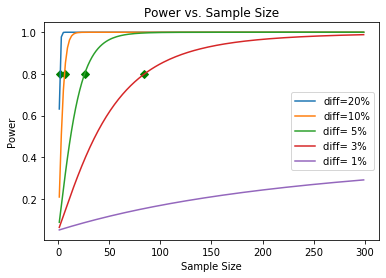

In [17]:
#using estimates of R squared and standard deviation for SA3 level to get a rough number of sample size
test_ttest_power_diff(0.75, 0.065, sample1_size=300, alpha=0.05, desired_power=0.8, mean_diff_percentages=[0.2, 0.1, 0.05, 0.03, 0.01])

In [20]:
def apply_r2(df):
    r2 = r2_score(df['WFH_Participation'],df['preds'])
    n = df['WFH_Participation'].shape[0]
    #adj_r2 = (1 - (1-r2) * ( (n - 1) / (n - p - 1) ))
    return pd.Series( dict(  r2 = r2) )

In [173]:
df_sa2_multi_ttest = pd.read_csv('{}\SA2_multi_test.csv'.format(nb_path))
df_sa3_multi_ttest = pd.read_csv('{}\SA3_multi_test.csv'.format(nb_path))

comparison_df = df_sa2_multi_ttest.groupby( 'iteration' ).apply( apply_r2 ).reset_index()
comparison_df = comparison_df.merge(df_sa3_multi_ttest.groupby( 'iteration' ).apply( apply_r2 ).reset_index(),
                                    on='iteration',
                                   suffixes = ('_SA2','_SA3'))

comparison_df.head()

iteration    r2_SA2    r2_SA3
0          1  0.834737  0.833253
1          2  0.785019  0.755100
2          3  0.841112  0.826564
3          4  0.740549  0.804707
4          5  0.741524  0.754408

In [174]:
comparison_df.describe()

iteration      r2_SA2      r2_SA3
count  200.000000  200.000000  200.000000
mean   100.500000    0.789609    0.759062
std     57.879185    0.064215    0.064740
min      1.000000    0.582774    0.478317
25%     50.750000    0.742309    0.729609
50%    100.500000    0.788889    0.773009
75%    150.250000    0.841119    0.799694
max    200.000000    0.900671    0.870012

In [175]:
import scipy.stats as stats
stats.ttest_ind(comparison_df['r2_SA2'],comparison_df['r2_SA3'])

Ttest_indResult(statistic=4.73754065447105, pvalue=3.0150032546372624e-06)

In [183]:
print('p-value {:5f}'.format(stats.ttest_ind(comparison_df['r2_SA2'],comparison_df['r2_SA3'])[1]))

p-value 0.000003


With a p-value that low, I am confident that modelling with SA2 is more effective than with SA3. Uniformly across the distribution of training outcomes, SA3 trained data performed less effectively than SA2. That said, the time to run the modelling process was *significantly* faster for SA3, at ~1 vs ~12 minutes, but that's not really so much on a human time scale (and especially in comparison to the several hours a GridSearch on SA1 level data can take).

### Comparing SA1 performance
Based on the above power analysis, given a rough estimate of an expected difference of 0.2 between the SA2 and SA1 levels of modelling, a sample size of 20 should be far more than enough to provide sufficient statistical power in comparing outcomes.

In [19]:
# Dropping year of arrival and country of birth of parents
# as it rarely appeared in top features and when it did was mostly a proxy for age
# Replace Age with Sex based on its much greater effects noted above
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Sex','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

X_sa1, y_sa1 = cnss_func.WFH_create_Xy('SA1', load_tables, load_features)

In [24]:
filename_path = '{}\SA1_multi_test.csv'.format(nb_path)
SA1_testing_path = multi_ttsplit_testing(X_sa1, y_sa1, filename_path, 20)
print(SA1_testing_path)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [32:07<00:00, 94.66s/it]


C:\Users\kempbri\OneDrive - Mars Inc\Documents\GitHub\Census-ASGS-Level-and-Model-Sensitivity\SA1_multi_test.csv


In [25]:
df_sa1_multi_ttest = pd.read_csv('{}\SA1_multi_test.csv'.format(nb_path))
df_sa2_multi_ttest = pd.read_csv('{}\SA2_multi_test.csv'.format(nb_path))

comparison_df = df_sa1_multi_ttest.groupby( 'iteration' ).apply( apply_r2 ).reset_index()
comparison_df = comparison_df.merge(df_sa2_multi_ttest.groupby( 'iteration' ).apply( apply_r2 ).reset_index(),
                                    on='iteration',
                                   suffixes = ('_SA1','_SA2'),
                                   how='inner')

comparison_df.head()

iteration    r2_SA1    r2_SA2
0          1  0.562512  0.834737
1          2  0.551825  0.785019
2          3  0.558934  0.841112
3          4  0.566090  0.740549
4          5  0.570825  0.741524

In [26]:
comparison_df.describe()

iteration     r2_SA1     r2_SA2
count   20.00000  20.000000  20.000000
mean    10.50000   0.563304   0.806731
std      5.91608   0.006923   0.059984
min      1.00000   0.551825   0.700539
25%      5.75000   0.558559   0.762213
50%     10.50000   0.563207   0.802758
75%     15.25000   0.567092   0.849158
max     20.00000   0.576249   0.895964

In [28]:
import scipy.stats as stats
stats.ttest_ind(comparison_df['r2_SA2'],comparison_df['r2_SA1'])

Ttest_indResult(statistic=18.029230920311793, pvalue=3.223982166745074e-20)

In [29]:
print('p-value {:5f}'.format(stats.ttest_ind(comparison_df['r2_SA2'],comparison_df['r2_SA1'])[1]))

p-value 0.000000


# Conclusion

So it's pretty definitive (even though it was obvious for the SA1 level from the discrepancy): SA2 performs the best!

# Appendix
For further insights into the drivers of working from home behaviours using the tools analysed in this workbook, see the other workbook in this repo "Working from home feature analysis.ipynb". The below is the beginnings of these workings as they applied to the above differentiation of modelling power between data levels.

### Modelling excluding Age
The below shows slight improvements when removing age from the list of included characteristics, which is incredibly surprising to me given its power in the above models. This holds for both SA3 and SA2 levels.

In [133]:
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

model_sa3_ageless, X_train_sa3_ageless, X_test_sa3_ageless, y_train_sa3_ageless, y_test_sa3_ageless = (cnss_func.model_WFH('SA3', 
                                                                                                       load_tables, 
                                                                                                       load_features))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.745, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.781, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.659, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.748, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.780, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.682, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.9s finished


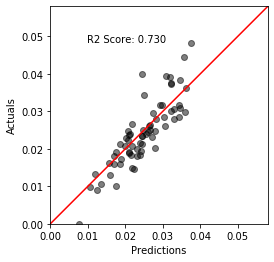

In [134]:
cnss_func.model_analyse_pred(X_test_sa3_ageless, y_test_sa3_ageless, model_sa3_ageless)

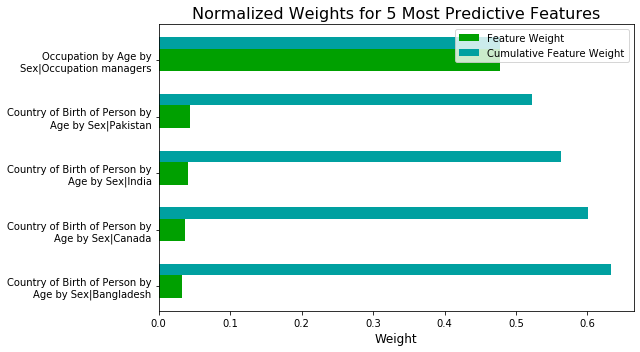

In [135]:
cnss_func.feature_plot_h(model_sa3_ageless.steps[1][1], X_train_sa3_ageless, 5)

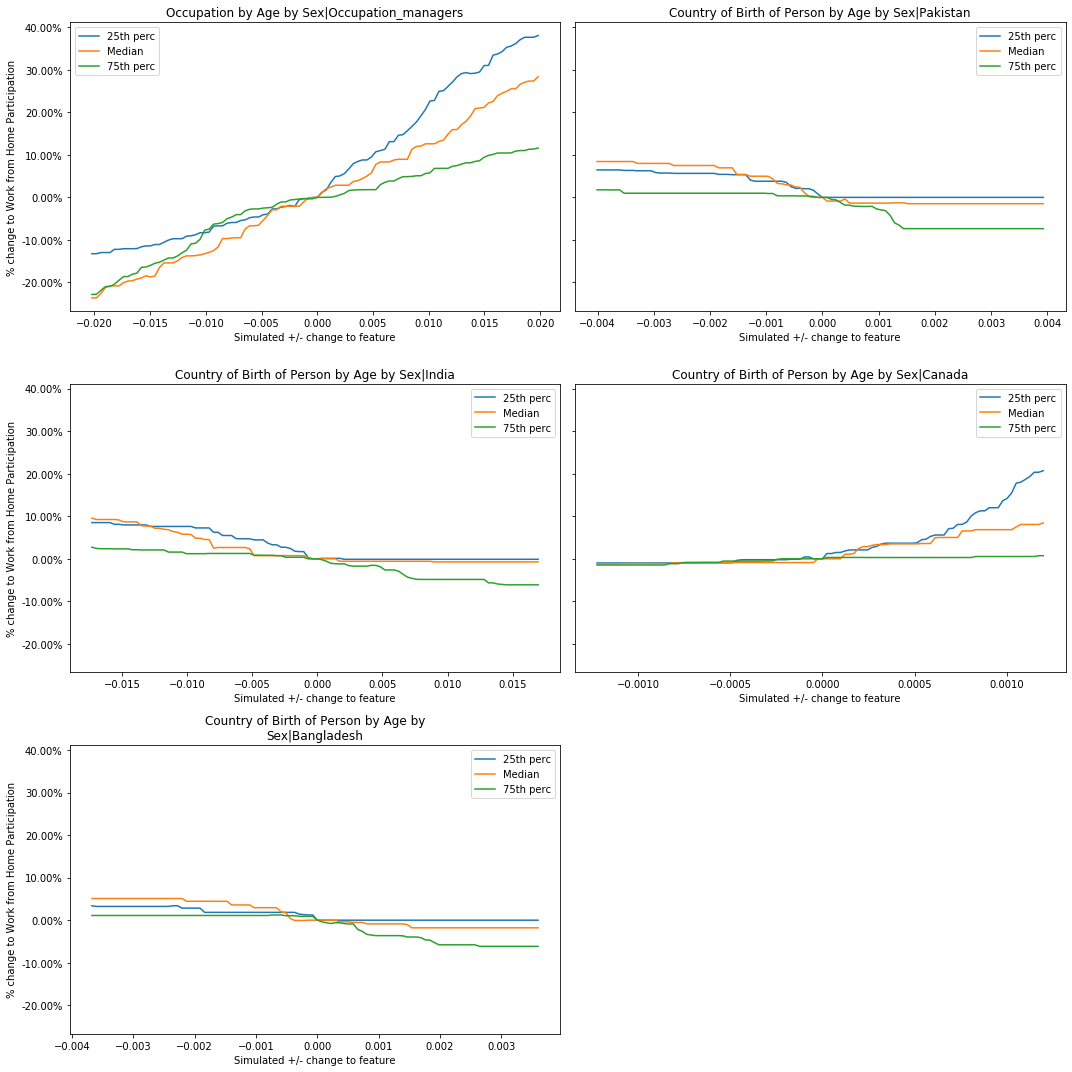

In [136]:
cnss_func.feature_impact_plot(model_sa3_ageless.steps[1][1], 
                              X_train_sa3_ageless, 5, 'Work from Home Participation', model_sa3_ageless)

#### SA2 analysis with age removed

In [137]:
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

model_sa2_ageless, X_train_sa2_ageless, X_test_sa2_ageless, y_train_sa2_ageless, y_test_sa2_ageless = (cnss_func.model_WFH('SA2', 
                                                                                                       load_tables, 
                                                                                                       load_features))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.737, total=   0.8s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.710, total=   0.8s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.817, total=   0.7s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.748, total=   1.4s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.710, total=   1.3s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.822, total=   1.4s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.740, total=   0.7s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.712, total=   0.7s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.821, total=   0.7s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   18.8s finished


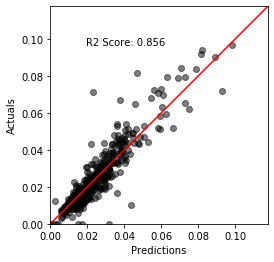

In [138]:
cnss_func.model_analyse_pred(X_test_sa2_ageless, y_test_sa2_ageless, model_sa2_ageless)

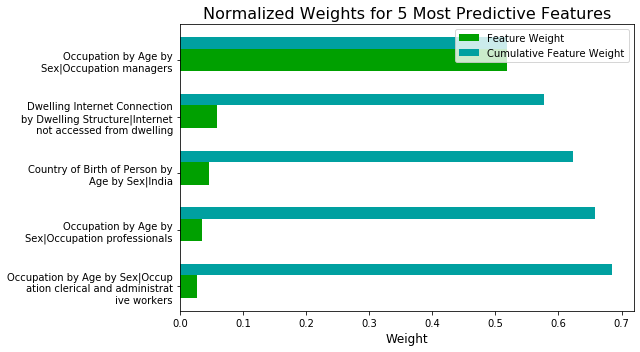

In [139]:
cnss_func.feature_plot_h(model_sa2_ageless.steps[1][1], X_train_sa2_ageless, 5)

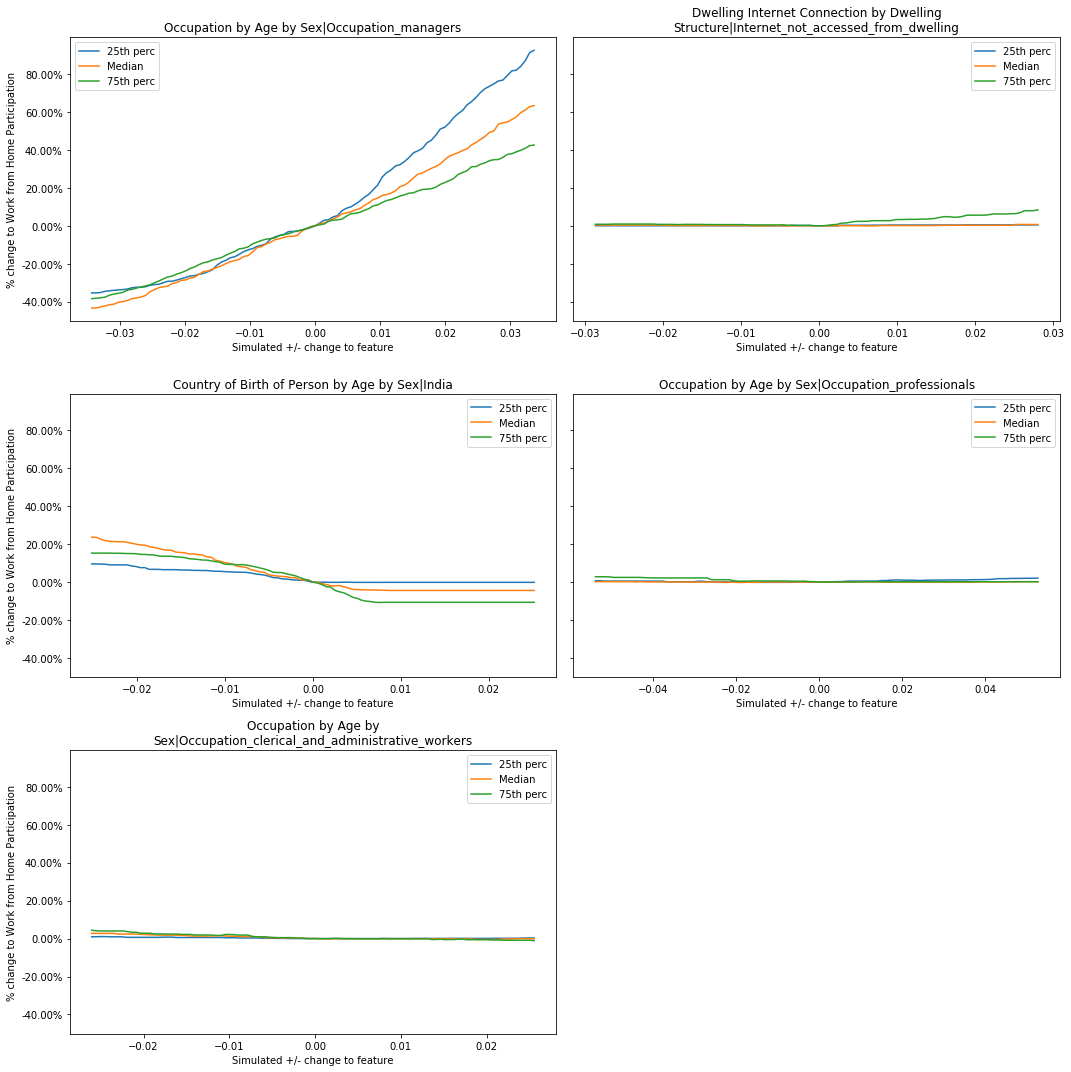

In [140]:
cnss_func.feature_impact_plot(model_sa2_ageless.steps[1][1], 
                              X_train_sa2_ageless, 5, 'Work from Home Participation', model_sa2_ageless)

### Modelling excluding Age but including Sex
At the SA3 level, adding Sex into the mix does indeed improve performance. It really reinforces the relationship with "Managers", although interestingly does show a much stronger response to Male rather than Female managers.

In [2]:
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Sex','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

model_sa3_sex_exA, X_train_sa3_sex_exA, X_test_sa3_sex_exA, y_train_sa3_sex_exA, y_test_sa3_sex_exA = (cnss_func.model_WFH('SA3', 
                                                                                                       load_tables, 
                                                                                                       load_features))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.716, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.800, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.718, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.722, total=   0.4s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.789, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.705, total=   0.3s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.716, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.800, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.718, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=40 .........................
[CV]  clf__max_depth=32, clf__n_estimators=40, score=0.722, total=   0.3s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s finished


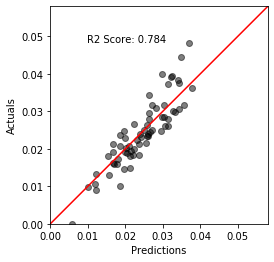

In [142]:
cnss_func.model_analyse_pred(X_test_sa3_sex_exA, y_test_sa3_sex_exA, model_sa3_sex_exA)

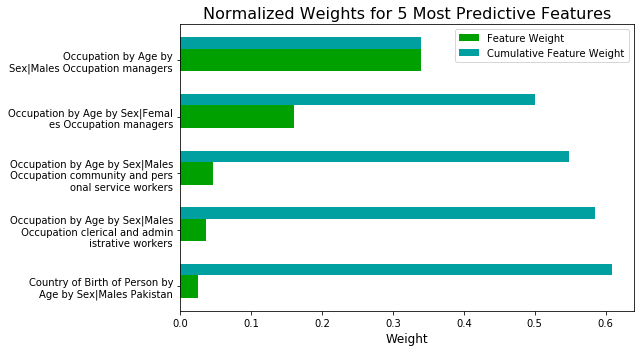

In [143]:
cnss_func.feature_plot_h(model_sa3_sex_exA.steps[1][1], X_train_sa3_sex_exA, 5)

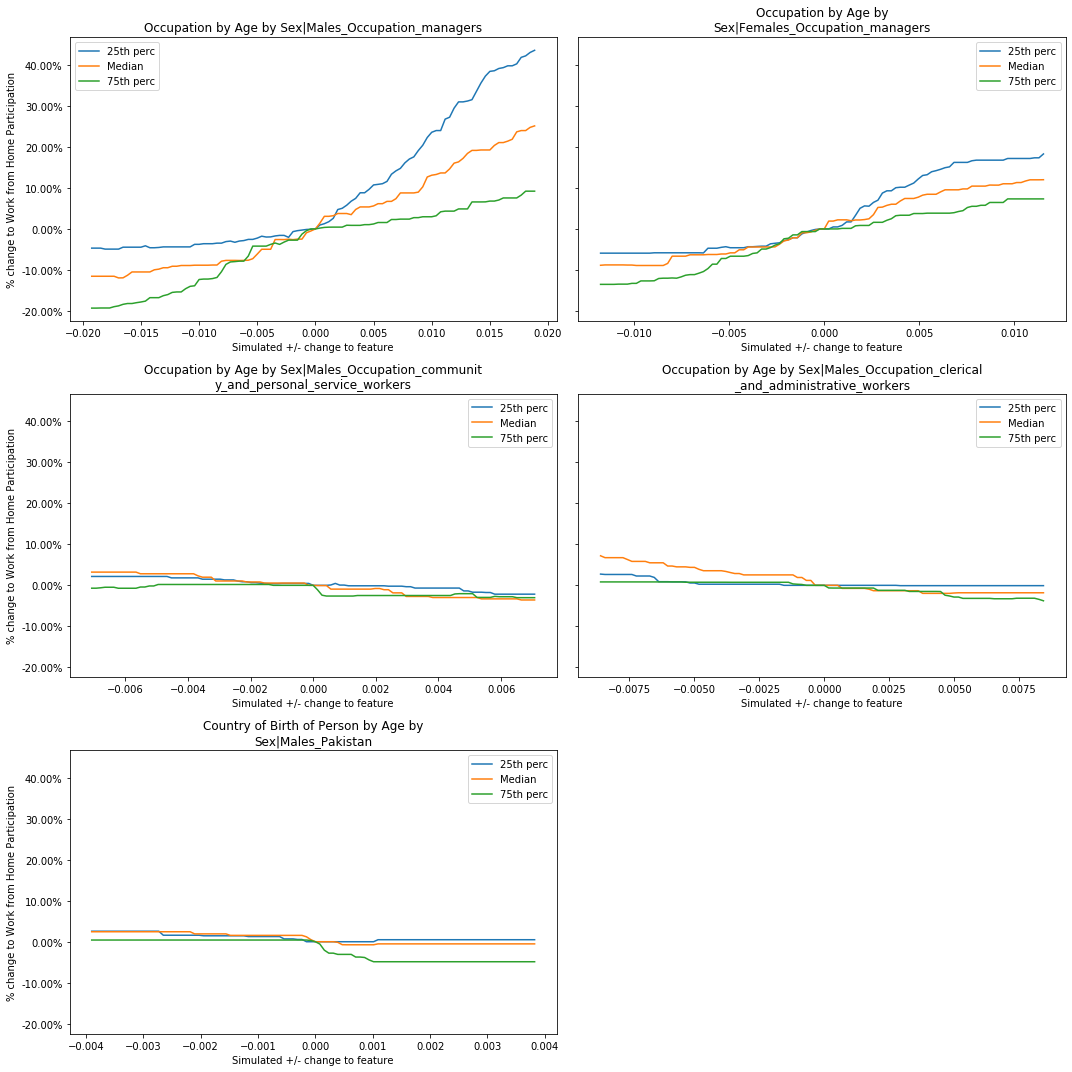

In [6]:
cnss_func.feature_impact_plot(model_sa3_sex_exA.steps[1][1], 
                              X_train_sa3_sex_exA, 5, 'Work from Home Participation', model_sa3_sex_exA)

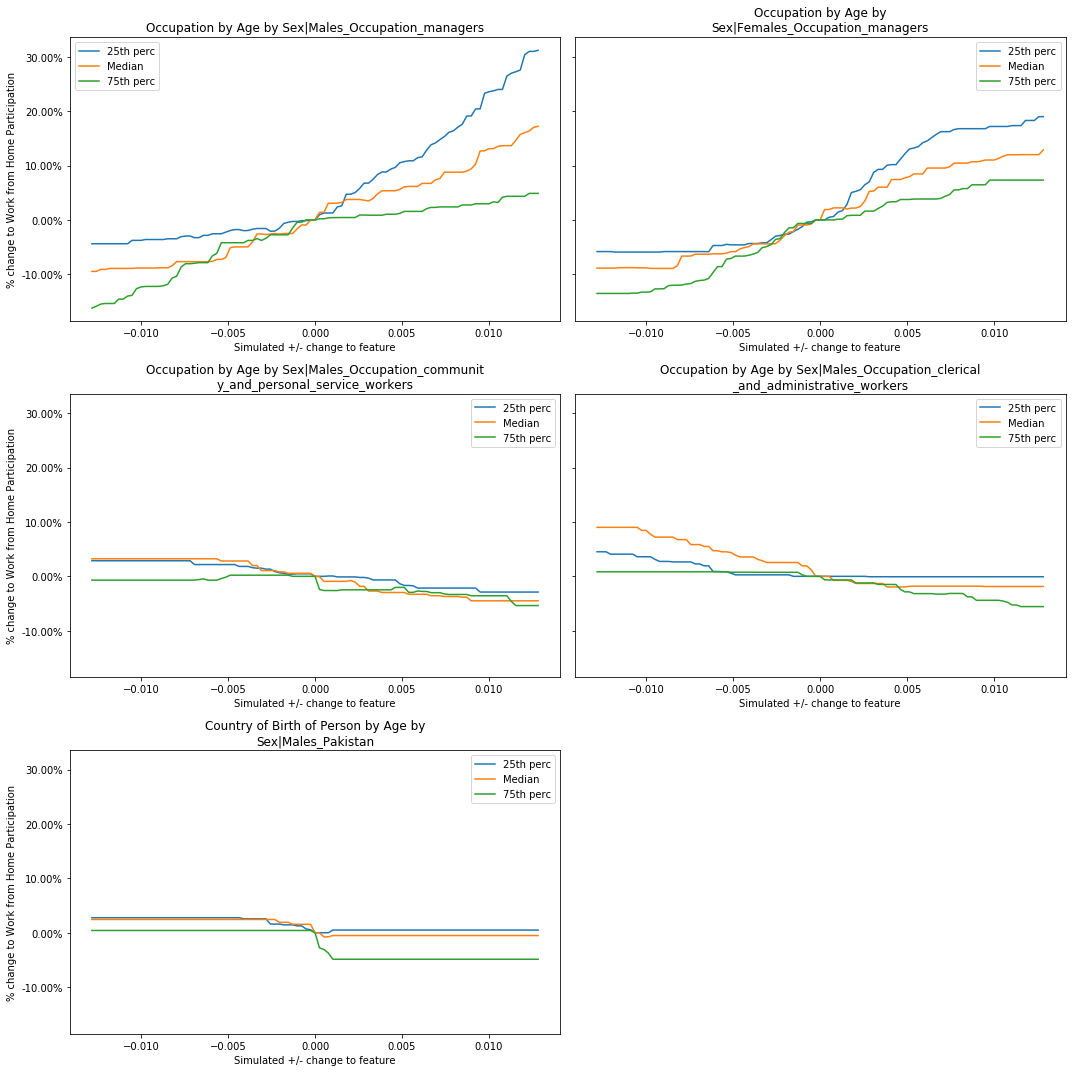

In [5]:
# Keep x-axis constant in order to make comparisons between features easier
cnss_func.feature_impact_plot(model_sa3_sex_exA.steps[1][1], 
                              X_train_sa3_sex_exA, 5, 'Work from Home Participation', model_sa3_sex_exA, True)

### Modelling Including sex but excluding age at SA2 level

In [7]:
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Sex','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

model_sa2_sex_exA, X_train_sa2_sex_exA, X_test_sa2_sex_exA, y_train_sa2_sex_exA, y_test_sa2_sex_exA = (cnss_func.model_WFH('SA2', 
                                                                                                       load_tables, 
                                                                                                       load_features))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.770, total=   1.7s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.717, total=   1.5s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.828, total=   1.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.780, total=   2.6s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.728, total=   2.3s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.834, total=   2.3s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.770, total=   1.2s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.717, total=   1.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.826, total=   1.3s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   32.4s finished


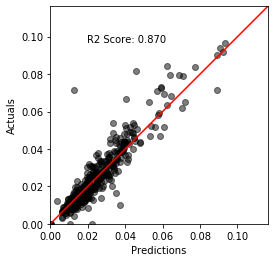

In [146]:
cnss_func.model_analyse_pred(X_test_sa2_sex_exA, y_test_sa2_sex_exA, model_sa2_sex_exA)

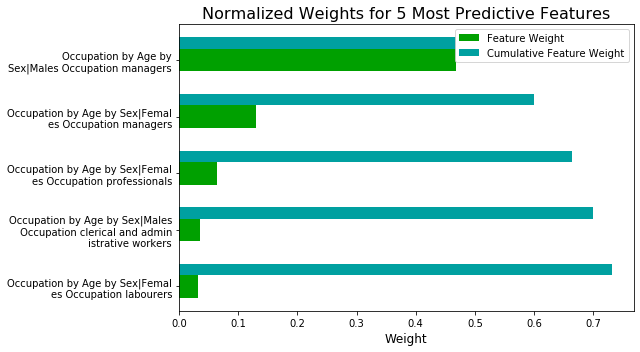

In [147]:
cnss_func.feature_plot_h(model_sa2_sex_exA.steps[1][1], X_train_sa2_sex_exA, 5)

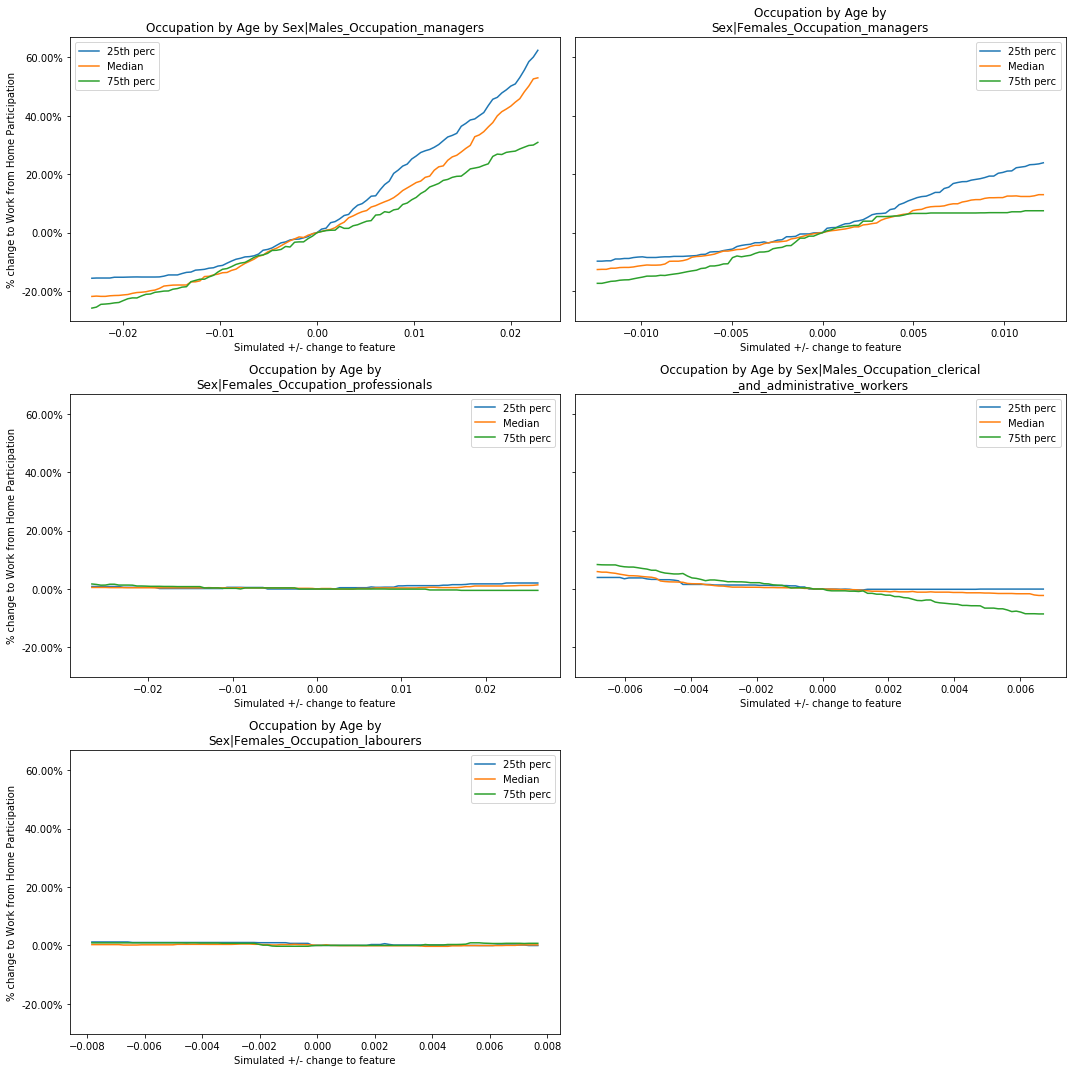

In [148]:
cnss_func.feature_impact_plot(model_sa2_sex_exA.steps[1][1], 
                              X_train_sa2_sex_exA, 5, 'Work from Home Participation', model_sa2_sex_exA)

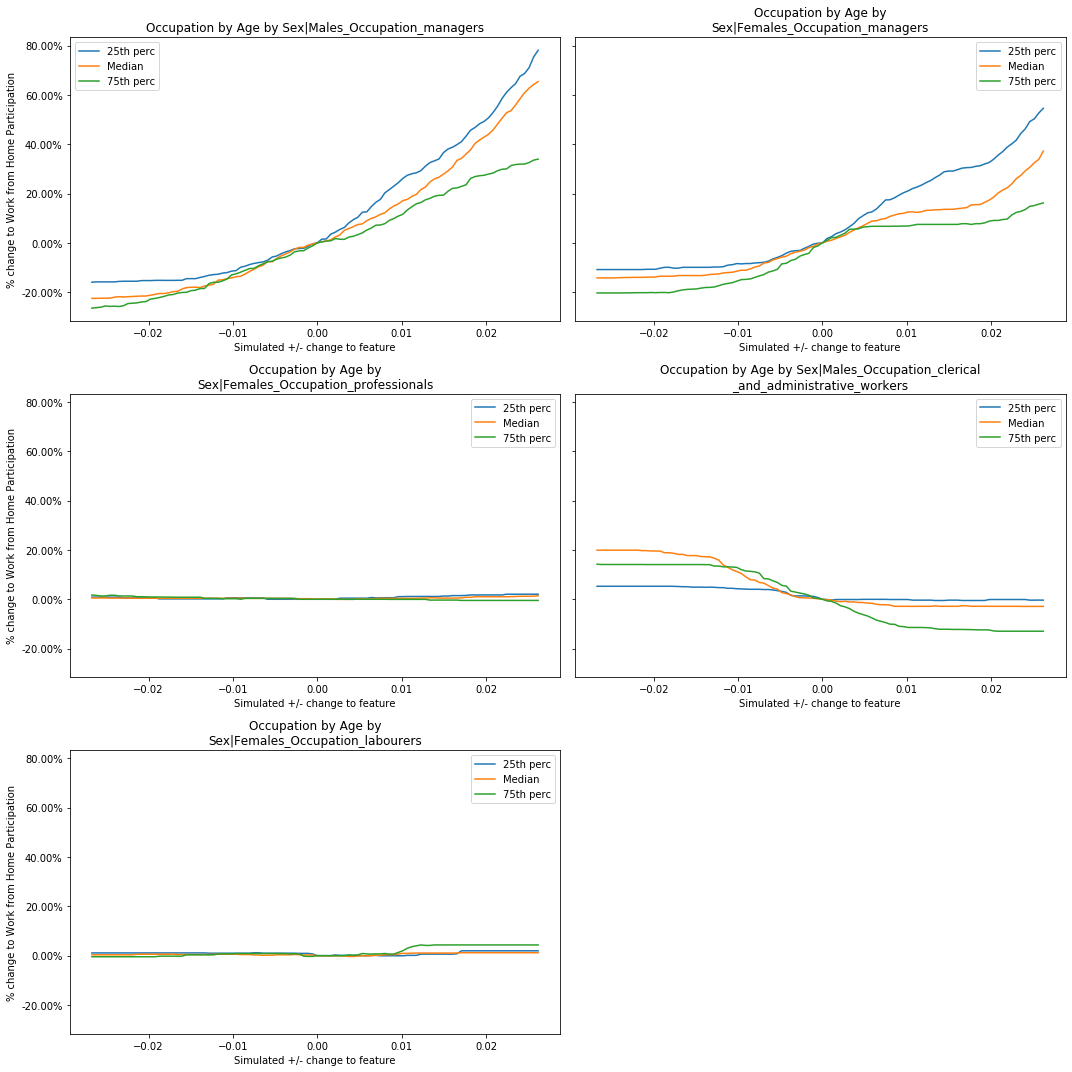

In [8]:
cnss_func.feature_impact_plot(model_sa2_sex_exA.steps[1][1], 
                              X_train_sa2_sex_exA, 5, 'Work from Home Participation', model_sa2_sex_exA, True)

### For good measure, including both age and sex
The impact of including both and sex was well within the range of R2 variation I saw in various points of modelling driven simply by changing the random_state parameter in the test_train_split function, so I'm hesitant to say that it adds any real value. Probably the key insight I saw here is that the only age group with a higher feature importance of Female vs Male populations was in the 45-54 age group. But really, the effects of being in Management is so important it is really the key to working from home (on census day).

At the SA2 level performance clearly decreased, perhaps showing signs of the model becoming prone to overfitting, or simply some residual impact of the test_train_split.

In [149]:
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Age','Sex','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

model_sa3_sex, X_train_sa3_sex, X_test_sa3_sex, y_train_sa3_sex, y_test_sa3_sex = (cnss_func.model_WFH('SA3', 
                                                                                                       load_tables, 
                                                                                                       load_features))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.751, total=   0.6s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.799, total=   0.6s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.799, total=   0.6s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.768, total=   1.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.797, total=   1.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.800, total=   1.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.751, total=   0.5s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.799, total=   0.6s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.799, total=   0.6s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   15.0s finished


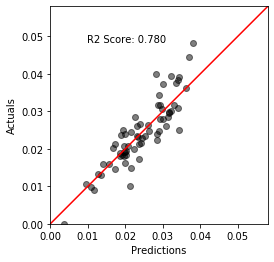

In [150]:
cnss_func.model_analyse_pred(X_test_sa3_sex, y_test_sa3_sex, model_sa3_sex)

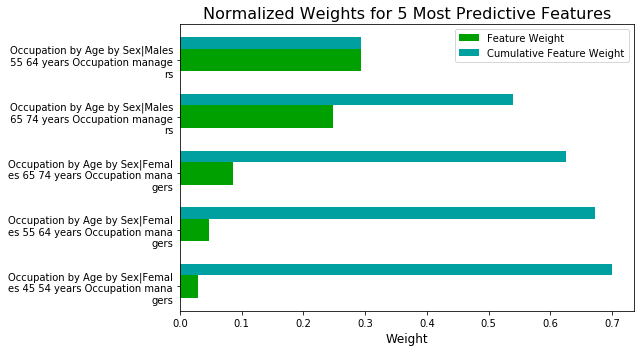

In [151]:
cnss_func.feature_plot_h(model_sa3_sex.steps[1][1], X_train_sa3_sex, 5)

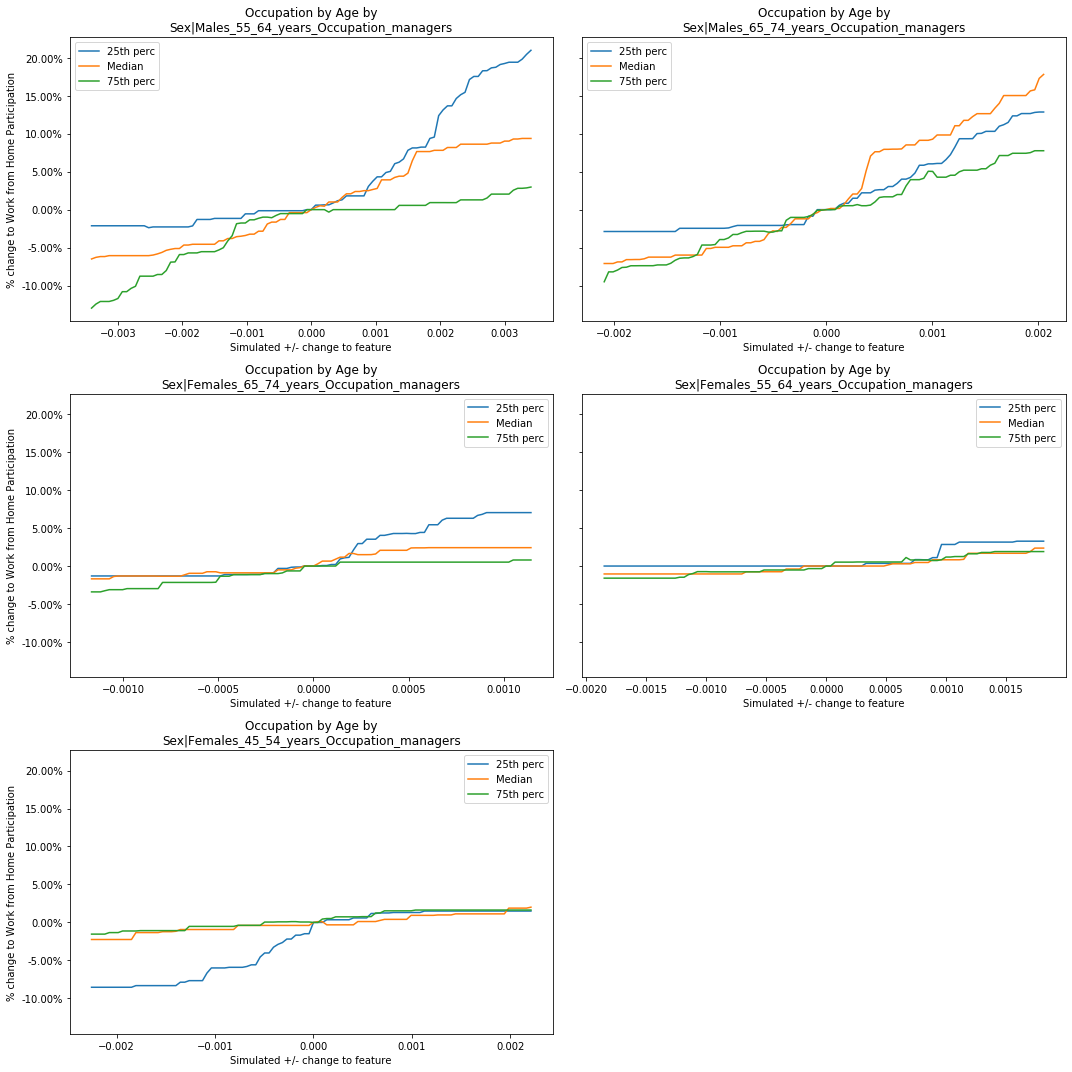

In [152]:
cnss_func.feature_impact_plot(model_sa3_sex.steps[1][1], 
                              X_train_sa3_sex, 5, 'Work from Home Participation', model_sa3_sex)

### Including age and sex at SA2 level

In [153]:
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Age','Sex','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth']

model_sa2_sex, X_train_sa2_sex, X_test_sa2_sex, y_train_sa2_sex, y_test_sa2_sex = (cnss_func.model_WFH('SA2', 
                                                                                                       load_tables, 
                                                                                                       load_features))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.807, total=   5.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.673, total=   4.7s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.834, total=   4.7s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.805, total=   9.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.680, total=   8.6s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.835, total=   9.3s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.807, total=   4.8s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.674, total=   5.0s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.831, total=   5.6s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.1min finished


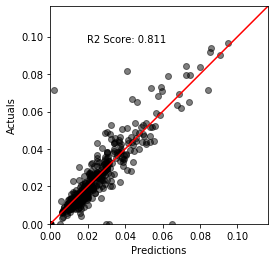

In [154]:
cnss_func.model_analyse_pred(X_test_sa2_sex, y_test_sa2_sex, model_sa2_sex)

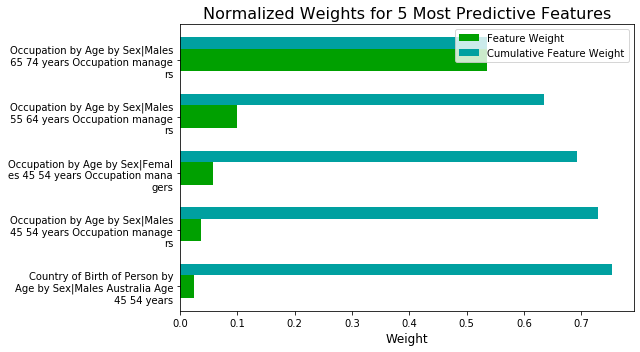

In [155]:
cnss_func.feature_plot_h(model_sa2_sex.steps[1][1], X_train_sa2_sex, 5)

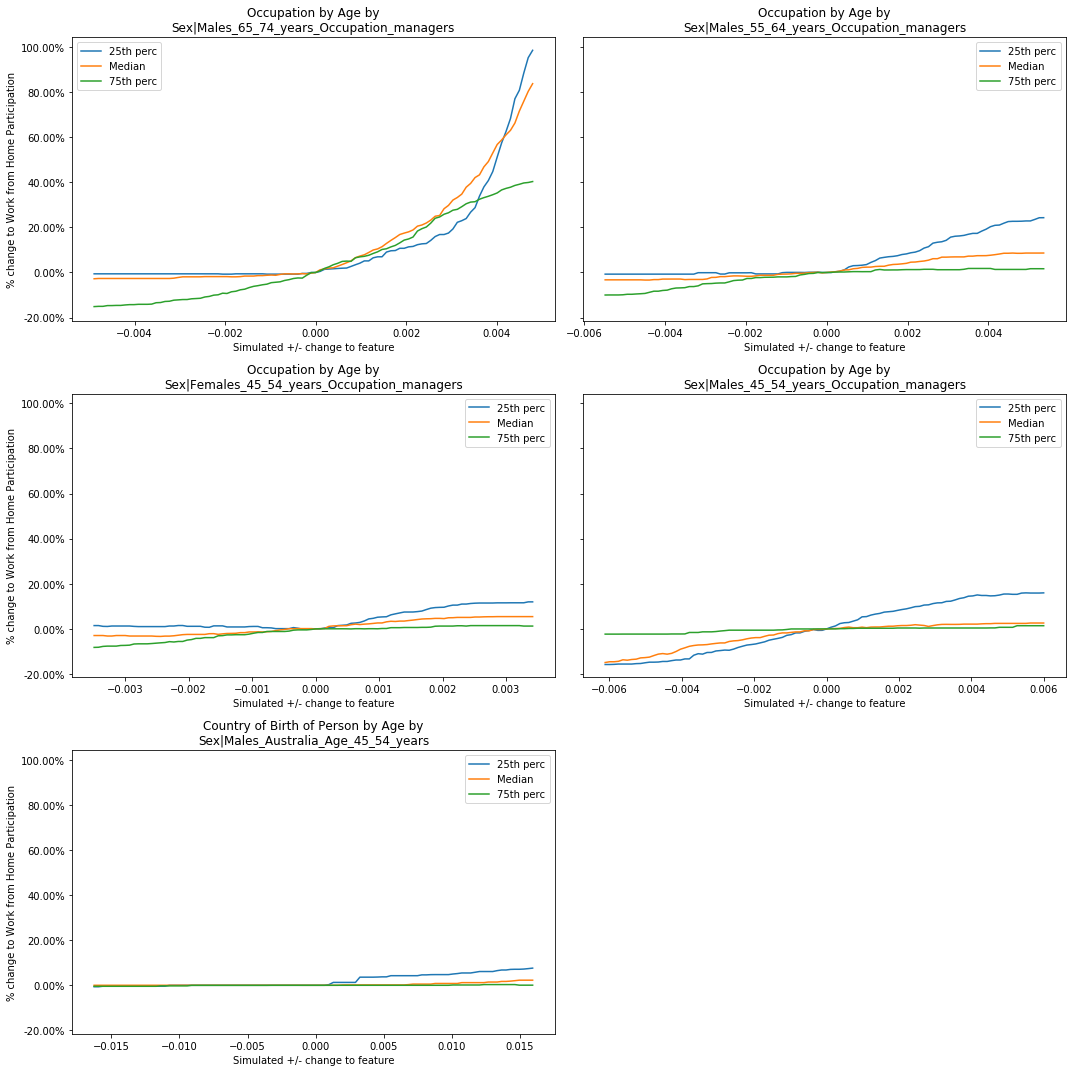

In [156]:
cnss_func.feature_impact_plot(model_sa2_sex.steps[1][1], 
                              X_train_sa2_sex, 5, 'Work from Home Participation', model_sa2_sex)

## Do features stay consistent across different levels?
You can see in the above analyses that I consistently pulled the feature importances and while there was some relative consistency across the top 10 drivers, it would also be good to quantify the variance rather than just eyballing it. Accordingly, the appropriate move would be to train the models, output the feature importance figures into a table and subtract them from one another based on the different levels, e.g. SA3 vs SA2 vs SA1.   
   
This could then be benchmarked vs a random distribution of differences to infer the consistency of feature importance.

## Future ideas: Another use of the higher-level data
From the above, the use of SA2 level data was pretty poor at predicting, so as a final output, what happens if we simply assign the work from home participation rate to any SA2 level region to be that of the SA3 region predicted by the much more robust trained SA3 model? E.g. if the SA2 level region is 115039941 then return the prediction for the SA3 region 11503 using the SA3 trained model. Because this is simply prediction participation rates rather than absolute values, the model should be able to handle this fairly well. Alternatively, aggregate the results of predictions at the SA2 level to return SA3 level predictions (by weighting the regions by population and then grouping by the first 5 digits) and see how effective this is.

In [2]:
# Show tables which have the above fields of information available
df_meta = pd.read_csv('{}\Data\Metadata\Metadata_2016_refined.csv'.format(nb_path))
df_m_refined = df_meta[(df_meta['Age'] > 0) |
                      (df_meta['Income'] > 0) |
                      (df_meta['Occupation'] > 0) |
                      (df_meta['Family Composition'] > 0) |
                      (df_meta['Internet status'] > 0) |
                      (df_meta['Building occupation status'] > 0) |
                      (df_meta['Number of Bedrooms'] > 0) |
                      (df_meta['Place of Birth'] > 0) |
                      (df_meta['Country of Birth of Parents'] > 0) |
                      (df_meta['Year of Arrival'] > 0)]
tables_to_load = df_m_refined['Profile table'].unique().tolist()
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']